# Titanic Survivor Classification

In this kernel, we are going to apply machine learning techniques to create a model that predicts which passengers survived the Titanic shipwreck.

I have spent a lot of time on EDA and feature engineering, so these sections have a large volumn. 

Below is the outline of this kernel:
1. Importing Required Libraries
2. Defining Custom Functions
3. Reading Data
4. Variables Description
5. EDA
6. Feature Engineering
7. Modeling
8. Evaluation
9. Conclusion

# Importing Required Libraries

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import missingno as msno
import warnings
from catboost import CatBoostClassifier
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from scipy import stats

# Defining Custom Functions

In [207]:
def beautified_confusion_matrix(confusion_matrix, model_name):
    sns.heatmap(
        confusion_matrix,
        cmap = 'Blues',
        annot = True,
        fmt = 'g',
        square = True,
        xticklabels = ["Didn't Survive", "Survived"],
        yticklabels = ["Didn't Survive", "Survived"]
    ).set(
        xlabel = 'Prediction',
        ylabel = 'Actual',
        title = f'{model_name} Confusino Matrix'
    )

# Reading Data

In [208]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

# Variables Description

| Variable  | Definition                                 | Key                                             |
|-----------|--------------------------------------------|-------------------------------------------------|
| survival  | Survival                                   | 0 = No, 1 = Yes                                 |
| pclass    | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                       |
| sex       | Sex                                        |                                                 |
| Age       | Age in years                               |                                                 |
| sibsp     | # of siblings / spouses aboard the Titanic |                                                 |
| parch     | # of parents / children aboard the Titanic |                                                 |
| ticket    | Ticket number                              |                                                 |
| fare      | Passenger fare                             |                                                 |
| cabin     | Cabin number                               |                                                 |
| embarked  | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton  |


# EDA

## Overview
I will make a copy of the original data and explore it using this copy. This allows us to easily revert to the original dataset when needed.

In [209]:
train_explore = train.copy()

Now, let's take a high-level look at the data.

In [210]:
train_explore.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [211]:
train_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [212]:
test.info() # to see if there are any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [213]:
# numerical data
train_explore.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [214]:
# categorical data
train_explore.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


Insights:
- Missing Values:
 - ``Cabin`` and ``Age`` have many missing values in both the training and test sets. We need to carefully determine how to impute these missing values.
 - ``Embarked`` has 2 missing values in the training set.
 - ``Fare`` has 1 missing value in the test set.
- ``Survived`` is our target variable.
- ``Pclass`` should probablly be considered a categorical feature rather than numerical.
- ``Name`` and ``Ticket`` have many categories. If we one-hot encode them, it will result in more than a thousand new features. We should probablly perform feature engineering and not use these original features. 
- It might be helpful to add new features by binning ``Age`` adn ``Fare`` into subgroups.
- ``Ticket`` has duplicated values. One assumption could be that passengers with the same ticket number were part of the same group.


I will move the target variable to the rightmost position.

In [215]:
# Move the target variable to the rightmost position
target = train.pop("Survived")
train = pd.concat([train, target], axis = 1)

train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


## Categorical & Discrete Features 

In [216]:
print(f"categorical features: {train_explore.select_dtypes('object').columns.values}") # categorical features
print(f"discrete features:    {train_explore.select_dtypes('int64').columns.values}") # discrete features

categorical features: ['Name' 'Sex' 'Ticket' 'Cabin' 'Embarked']
discrete features:    ['PassengerId' 'Survived' 'Pclass' 'SibSp' 'Parch']


### Name

In [217]:
train_explore[["Name"]]

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
...,...
886,"Montvila, Rev. Juozas"
887,"Graham, Miss. Margaret Edith"
888,"Johnston, Miss. Catherine Helen ""Carrie"""
889,"Behr, Mr. Karl Howell"


Insights:
- We can extract titles (Mr, Miss, Mrs, etc.) from the ``Name`` feature.
- We can also identify families by extracting surnames (a word before the comma).

#### Create a New Feature "Title"

In [218]:
train_explore['Title'] = train_explore["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)

In [219]:
train_explore.groupby("Title", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"}).sort_values("Count", ascending = False)

,Title,Survived,Count
12,Mr,0.156673,517
9,Miss,0.697802,182
13,Mrs,0.792000,125
8,Master,0.575000,40
4,Dr,0.428571,7
15,Rev,0.000000,6
7,Major,0.500000,2
1,Col,0.500000,2
10,Mlle,1.000000,2
11,Mme,1.000000,1


"Mr," "Miss," "Mrs," "Master" are the most common titles with some other rare titles also present. I believe there are too many categories for the ``Title`` feature, so I will group them into subgroups. But before doing that, I want too see if the survival rate by female marriage status has any statistical significance. If not, I will combined them into one group.

Since we are comparing only 2 categories, we can test this with a T-test. 

In [220]:
# Separate data by each category
group1 = train_explore[train_explore['Title'] == 'Miss']['Survived']
group2 = train_explore[train_explore['Title'] == 'Mrs']['Survived']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(group1, group2)

print(f"t-statistic: {t_stat}, p-value: {p_value.round(3)}")

t-statistic: -1.8441341539173404, p-value: 0.066


Since 0.066 is greater than 0.05, there is not enough evidence to reject the null hypothesis at the 0.05 significance level.
This means that if the null hypothesis is true (assuming no effect or no difference), there is a 6.6% chance of observing the data or more extreme results by random chance alone.

I will group female's titles into one group.

In [221]:
title_mapping = {"Mr": "Mr",
                 "Miss": "Miss/Mrs/Ms",
                 "Mrs": "Miss/Mrs/Ms",
                 "Master": "Master",
                 "Dr": "Rare",
                 "Rev": "Rare", # Typically refers to someone who holds a clerical or ministerial position within a religious organization
                 "Major": "Rare", # Typically refers to someone who holds a senior position below that of a Lieutenant Colonel and above that of a Captain
                 "Col": "Rare", # Typically refers to someone who holds the military rank of Colonel
                 "Mlle": "Miss/Mrs/Ms", # "Mademoiselle" in French, equivalent to "Miss"
                 "Mme": "Miss/Mrs/Ms", # "Madame" in French, equivalent to "Mrs"
                 "Ms": "Miss/Mrs/Ms", # Neutral alternative to "Miss" or "Mrs"
                 "Capt": "Rare", # Typically refers to someone who holds the rank of Captain in the military or other organizations
                 "Lady": "Rare", # Women of high social rank or noble birth
                 "Johnkheer": "Rare", # Young nobleman
                 "Don": "Rare", # Man of high rank or nobility
                 "Countess": "Rare", # Wife or widow of a count in European countries with a nobiliary system
                 "Sir": "Rare" # Men of knighthood or baronetcy in English-speaking countries
                }
    
train_explore["Title"] = train_explore["Title"].map(title_mapping)

In [222]:
train_explore.groupby("Title", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,Title,Survived,Count
0,Master,0.575000,40
1,Miss/Mrs/Ms,0.739550,311
2,Mr,0.156673,517
3,Rare,0.363636,22


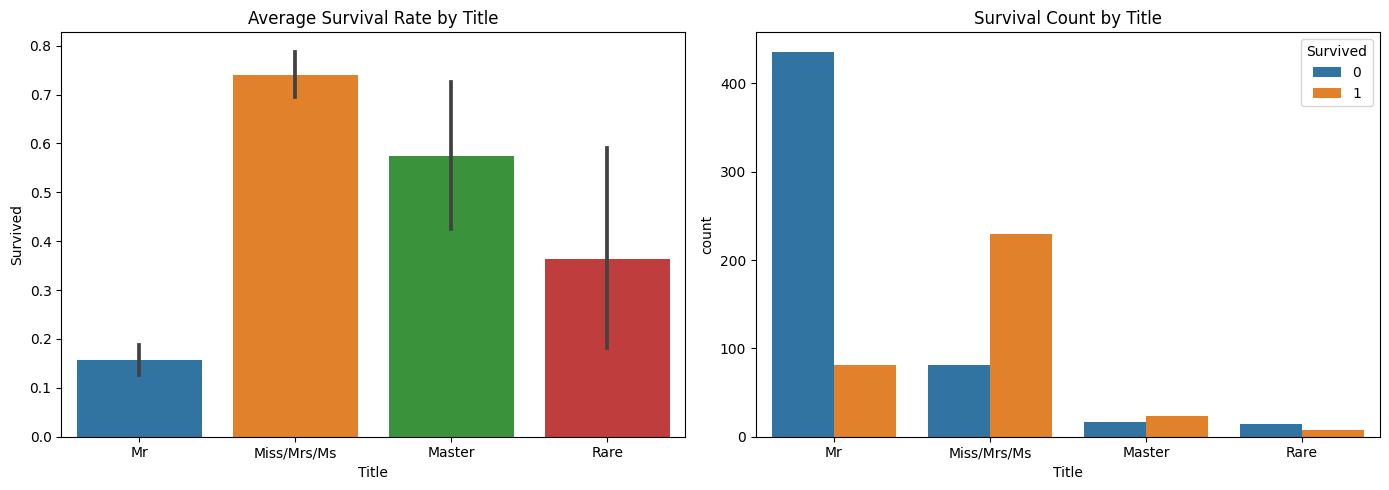

In [223]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=train_explore, x='Title', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by Title')

sns.countplot(data=train_explore, x='Title', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by Title')

plt.tight_layout();

In [224]:
# Separate data by each category
group1 = train_explore[train_explore['Title'] == "Mr"]['Survived']
group2 = train_explore[train_explore['Title'] == "Miss/Mrs/Ms"]['Survived']
group3 = train_explore[train_explore['Title'] == "Master"]['Survived']
group4 = train_explore[train_explore['Title'] == "Rare"]['Survived']

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group1, group2, group3, group4)

print(f"F-statistic: {f_stat}, p-value: {p_value.round(3)}")

F-statistic: 139.33045434299993, p-value: 0.0


Insights:
- It clearly shows that passengers with the title "Mr" had the lowest survival rate compared to those with other titles.
- "Miss/Mrs/Ms" and "Master" had more survivors than victims.
- The mean survival rate for each category shows statistically significant difference.

Let's see who falls under the "Master" subgroup.

In [225]:
train_explore[train_explore["Title"] == "Master"].describe().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,40.00,40.00,40.00,36.00,40.00,40.00,40.00
mean,414.98,0.57,2.62,4.57,2.30,1.38,34.70
std,301.72,0.50,0.63,3.62,1.91,0.54,28.05
min,8.00,0.00,1.00,0.42,0.00,0.00,8.52
25%,165.75,0.00,2.00,1.00,1.00,1.00,18.75
50%,345.00,1.00,3.00,3.50,1.00,1.00,29.06
75%,764.00,1.00,3.00,8.00,4.00,2.00,39.17
max,870.00,1.00,3.00,12.00,8.00,2.00,151.55


In [226]:
train_explore[train_explore["Title"] == "Master"]["Sex"].value_counts()

Sex
male    40
Name: count, dtype: int64

In [227]:
mask = (train_explore["Title"] == "Miss/Mrs/Ms") & (train_explore["Age"] < 10)
train_explore[mask]["Name"].head()

10              Sandstrom, Miss. Marguerite Rut
24                Palsson, Miss. Torborg Danira
43     Laroche, Miss. Simonne Marie Anne Andree
58                 West, Miss. Constance Mirium
119           Andersson, Miss. Ellis Anna Maria
Name: Name, dtype: object

Insights:
- As we can see from the first table, Passengers with the title "Master" have a mean ``Age`` of 4.57 and a standard deviation of 3.62. This means that the majority of passengers with the title "Master" are between 0.95 years old (4.57 - 3.62) and 8.19 years old (4.57 + 3.62).
- It is important to note that there are 40 children with the title "Master" and they are all male.
- As shown in the last cell, it seems that female children had the title "Miss" and are categorized under "Miss/Mrs/Ms". 

#### Create a New Feature "Surname"

In [228]:
train_explore["Surname"] = train_explore["Name"].str.extract('([A-Za-z]+(?=,))', expand=False)

In [229]:
train_explore["SurnameCount"] = train_explore.groupby("Surname")["PassengerId"].transform("count")

family_df = train_explore[train_explore["SurnameCount"] > 1]

In [230]:
family_df.groupby("SurnameCount", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,SurnameCount,Survived,Count
0,2,0.524096,166
1,3,0.370370,81
2,4,0.416667,60
3,5,0.000000,5
4,6,0.233333,30
5,7,0.000000,7
6,9,0.222222,9


Insights:
- It seems that as the survival rate was lower when the family size was bigger.
- The survival rate for family sizes of 2, 3, and 4 are not necessarily high, but they were higher than those for larger families (5-9).

Let's group the ``SurnameCount`` feature into 3 subgroups: Alone, Small (2-4), and Large (>=5).

In [231]:
train_explore["FamilySize"] = np.where(train_explore["SurnameCount"] == 1, 
                                       "Alone",
                                       np.where(train_explore["SurnameCount"].isin([2,3,4]), 
                                                "Small",
                                                "Large"))

In [232]:
train_explore.groupby("FamilySize", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,FamilySize,Survived,Count
0,Alone,0.358349,533
1,Large,0.176471,51
2,Small,0.462541,307


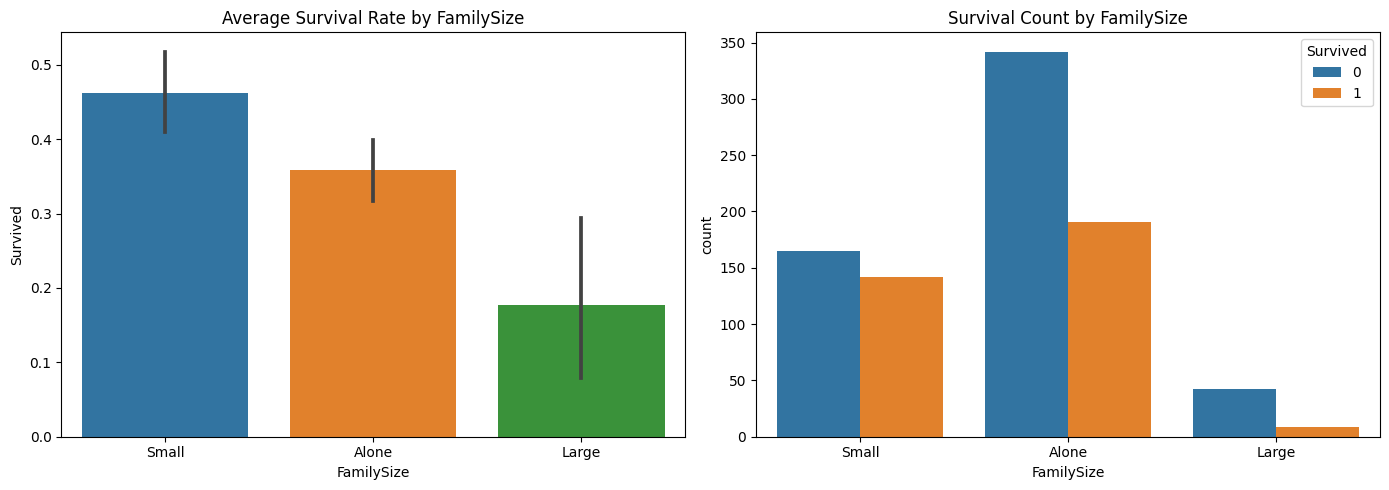

In [233]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=train_explore, x='FamilySize', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by FamilySize')

sns.countplot(data=train_explore, x='FamilySize', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by FamilySize')

plt.tight_layout();

In [234]:
# Separate data by each category
group1 = train_explore[train_explore['FamilySize'] == "Alone"]['Survived']
group2 = train_explore[train_explore['FamilySize'] == "Small"]['Survived']
group3 = train_explore[train_explore['FamilySize'] == "Large"]['Survived']

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group1, group2, group3)

print(f"F-statistic: {f_stat}, p-value: {p_value.round(3)}")

F-statistic: 9.558454761811404, p-value: 0.0


Insights:
- "Small" and "Alone" have a similar distribution while "Large" has a much lower survival rate.
- The mean survival rate for each category shows a statistically significant difference.

### Ticket

In [235]:
train_explore[train_explore["Ticket"].duplicated(keep = False)].sort_values("Ticket").head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,SurnameCount,FamilySize
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,B77,S,Miss/Mrs/Ms,Cherry,1,Alone
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,S,Rare,Rothes,1,Alone
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S,Miss/Mrs/Ms,Maioni,1,Alone
262,263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.6500,E67,S,Mr,Taussig,3,Small
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.6500,E67,S,Miss/Mrs/Ms,Taussig,3,Small
585,586,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.6500,E68,S,Miss/Mrs/Ms,Taussig,3,Small
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,S,Mr,Porter,1,Alone
475,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S,Mr,Clifford,1,Alone
523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C,Miss/Mrs/Ms,Hippach,2,Small
329,330,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C,Miss/Mrs/Ms,Hippach,2,Small


In [236]:
train_explore[train_explore["Ticket"].duplicated(keep = False)].sort_values("Ticket").tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,SurnameCount,FamilySize
142,143,1,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1,0,STON/O2. 3101279,15.850,NaN,S,Miss/Mrs/Ms,Hakkarainen,2,Small
403,404,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.850,NaN,S,Mr,Hakkarainen,2,Small
783,784,0,3,"Johnston, Mr. Andrew G",male,NaN,1,2,W./C. 6607,23.450,NaN,S,Mr,Johnston,2,Small
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.450,NaN,S,Miss/Mrs/Ms,Johnston,2,Small
436,437,0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2,W./C. 6608,34.375,NaN,S,Miss/Mrs/Ms,Ford,4,Small
736,737,0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.375,NaN,S,Miss/Mrs/Ms,Ford,4,Small
86,87,0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.375,NaN,S,Mr,Ford,4,Small
147,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.375,NaN,S,Miss/Mrs/Ms,Ford,4,Small
540,541,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.000,B22,S,Miss/Mrs/Ms,Crosby,2,Small
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.000,B22,S,Rare,Crosby,2,Small


Insights:
- It seems that group customers had the same ticket number.
 - It is possible that the same ticket number appears in the test set.
- Group customers can be family, friends, etc.
- Some tickets have non-number prefix, such as STON/O2 and W./C/. Does it have any meaning?

Similar to ``SurnameCount``, we can derive ``GroupSize`` using the ``Ticket`` feature.

#### Create a New Feature "GroupSize"

In [237]:
train_explore["GroupSize"] = train_explore.groupby("Ticket")["PassengerId"].transform("count")

In [238]:
train_explore.groupby("GroupSize", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,GroupSize,Survived,Count
0,1,0.297989,547
1,2,0.574468,188
2,3,0.698413,63
3,4,0.500000,44
4,5,0.000000,10
5,6,0.000000,18
6,7,0.238095,21


Insights:
- We can observe the similar pattern as ``SurnameCount``. The larger ``GroupSize`` (>=5) has lower survival rate.
- The survival rate for group sizes of 2, 3, and 4 were much higher than those travelling alone and those with the group size greater than 4.

Let's group the ``GroupSize`` feature into 3 subgroups: Alone, Small (2-4), and Large (>=5).

In [239]:
train_explore["GroupSize_cat"] = np.where(train_explore["GroupSize"] == 1, 
                                       "Alone",
                                       np.where(train_explore["GroupSize"].isin([2,3,4]), 
                                                "Small",
                                                "Large"))

In [240]:
train_explore.groupby("GroupSize_cat", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,GroupSize_cat,Survived,Count
0,Alone,0.297989,547
1,Large,0.102041,49
2,Small,0.589831,295


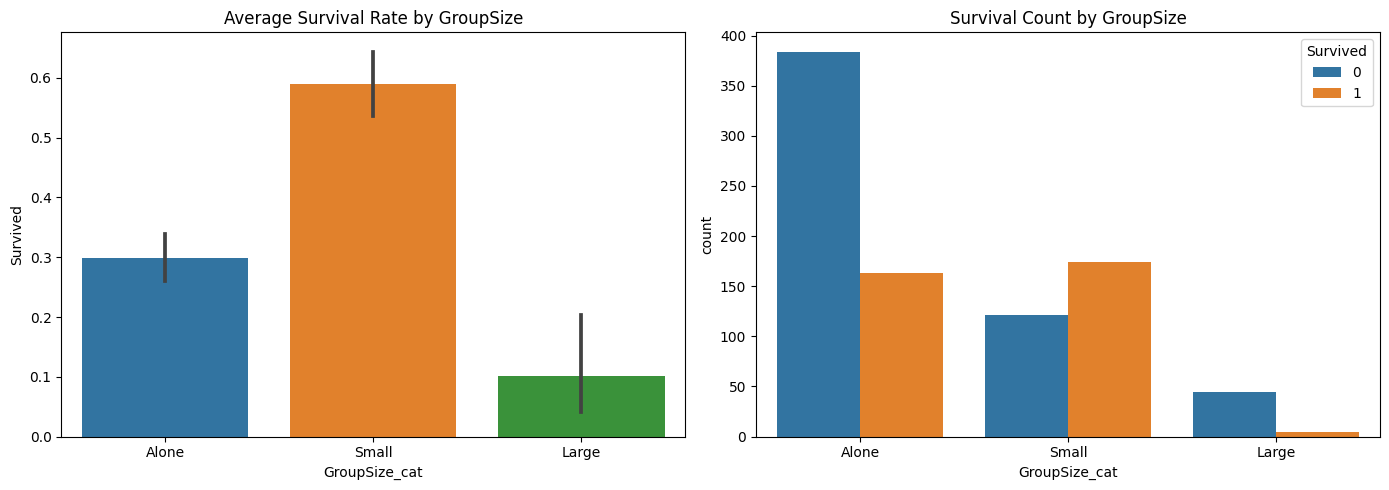

In [241]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=train_explore, x='GroupSize_cat', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by GroupSize')

sns.countplot(data=train_explore, x='GroupSize_cat', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by GroupSize')

plt.tight_layout();

In [242]:
# Separate data by each category
group1 = train_explore[train_explore['GroupSize_cat'] == "Alone"]['Survived']
group2 = train_explore[train_explore['GroupSize_cat'] == "Small"]['Survived']
group3 = train_explore[train_explore['GroupSize_cat'] == "Large"]['Survived']

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group1, group2, group3)

print(f"F-statistic: {f_stat}, p-value: {p_value.round(3)}")

F-statistic: 47.69345266913164, p-value: 0.0


Insights:
- Unlike ``FamilySize`` (where "Alone" and "Small" have a similar distribution), those with a group size categorized as "Small" had a mush higher survival rate than other group sizes.
- The mean survival rate for each category shows a statistically significant difference.

I also wonder if even a simpler binary feature (group? or alone?) will have a statistical significance.

#### Create a New Feature "Group?"

In [243]:
train_explore["Group?"] = np.where(train_explore["GroupSize"] > 1, 1, 0)

In [244]:
train_explore.groupby("Group?", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,Group?,Survived,Count
0,0,0.297989,547
1,1,0.520349,344


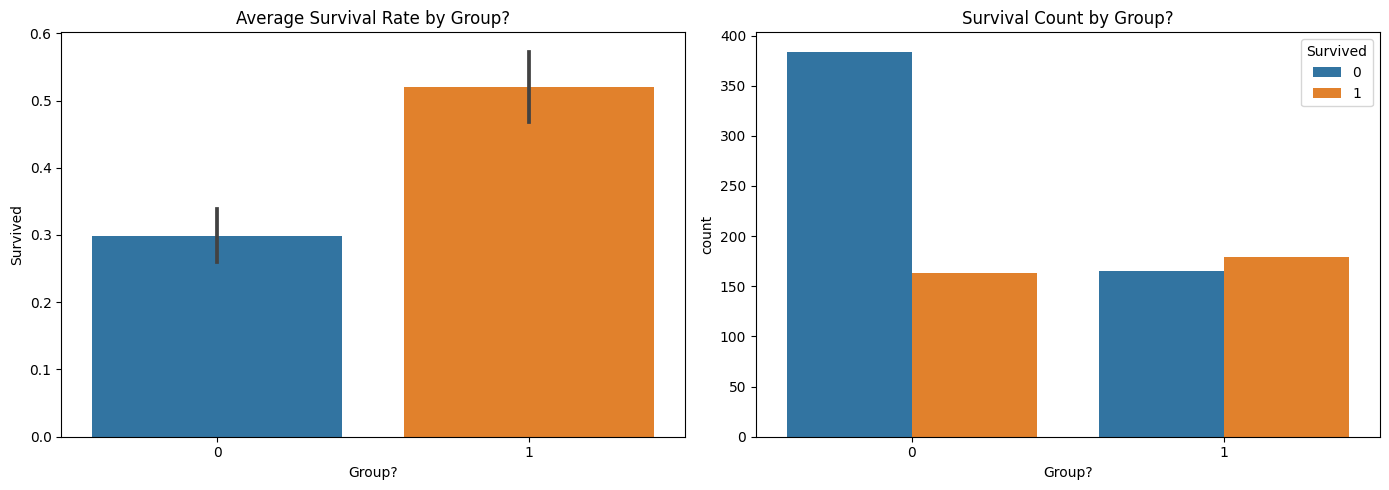

In [245]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=train_explore, x='Group?', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by Group?')

sns.countplot(data=train_explore, x='Group?', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by Group?')

plt.tight_layout();

In [246]:
# Separate data by each category
group1 = train_explore[train_explore['Group?'] == 'Y']['Survived']
group2 = train_explore[train_explore['Group?'] == 'N']['Survived']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(group1, group2)

print(f"t-statistic: {t_stat}, p-value: {p_value.round(3)}")

t-statistic: nan, p-value: nan


- The mean survival rate for each category shows a statistically significant difference.

### Pclass

In [247]:
train_explore.groupby("Pclass", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,Pclass,Survived,Count
0,1,0.629630,216
1,2,0.472826,184
2,3,0.242363,491


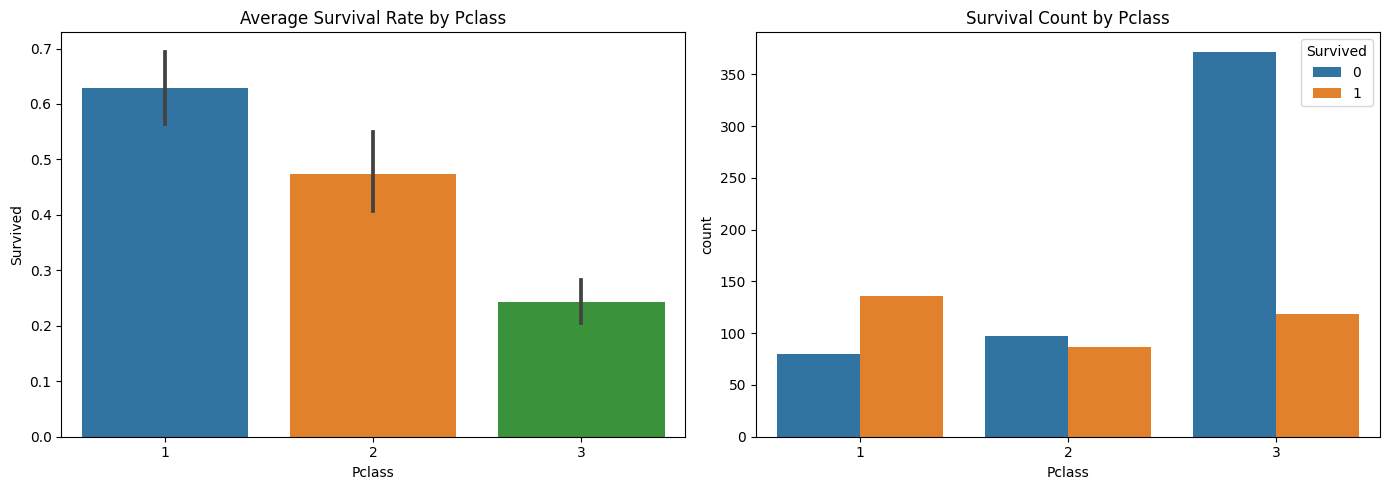

In [248]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=train_explore, x='Pclass', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by Pclass')

sns.countplot(data=train_explore, x='Pclass', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by Pclass')

plt.tight_layout();

In [249]:
# Separate data by each category
group1 = train_explore[train_explore['Pclass'] == 1]['Survived']
group2 = train_explore[train_explore['Pclass'] == 2]['Survived']
group3 = train_explore[train_explore['Pclass'] == 3]['Survived']

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group1, group2, group3)

print(f"F-statistic: {f_stat}, p-value: {p_value.round(3)}")

F-statistic: 57.964817590910116, p-value: 0.0


Insights:
- The 1st class had the highest survival rate (62%) with more survivors than victims, unlike the other classes. There were 216 1st-class passengers.
- The 3rd class had the lowest survival rate (24%) and the largest number of passengers (491).
- The mean survival rate for each category shows a statistically significant difference.

### Sex

In [250]:
train_explore.groupby("Sex", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,Sex,Survived,Count
0,female,0.742038,314
1,male,0.188908,577


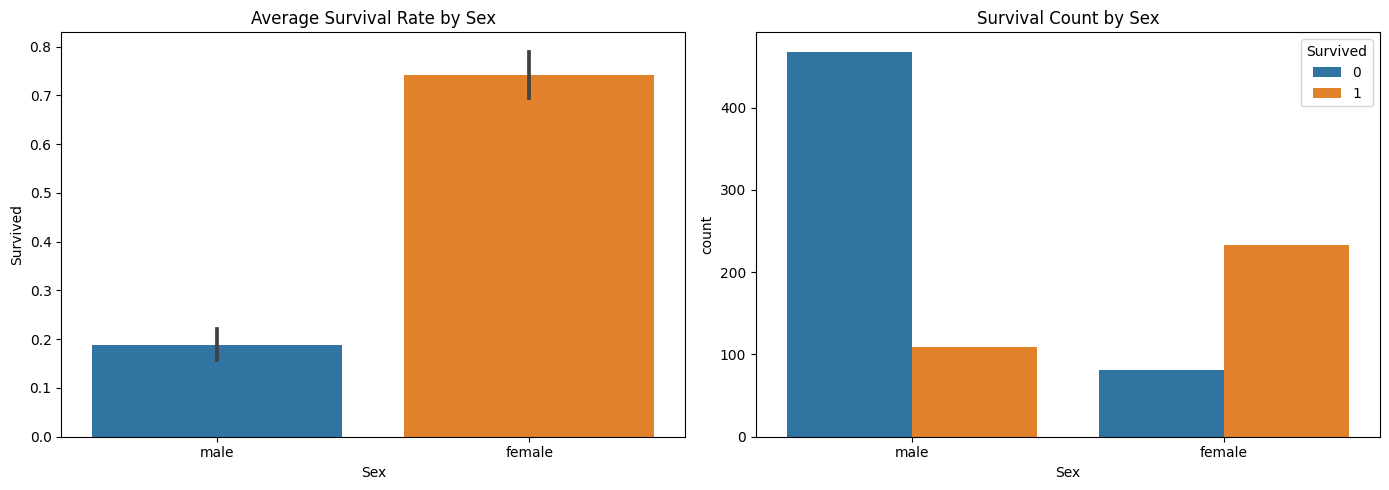

In [251]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=train_explore, x='Sex', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by Sex')

sns.countplot(data=train_explore, x='Sex', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by Sex')

plt.tight_layout();

In [252]:
# Separate data by each category
group1 = train_explore[train_explore['Sex'] == 'male']['Survived']
group2 = train_explore[train_explore['Sex'] == 'female']['Survived']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(group1, group2)

print(f"t-statistic: {t_stat}, p-value: {p_value.round(3)}")

t-statistic: -19.297816550123354, p-value: 0.0


Insights:
- Female passengers had the much higher survival rate (74%) than male passengers (19%).
- There were more male passengers (577) than female passengers (314).
- The mean survival rate for each category shows a statistically significant difference.

### Sibsp

In [253]:
train_explore.groupby("SibSp", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,SibSp,Survived,Count
0,0,0.345395,608
1,1,0.535885,209
2,2,0.464286,28
3,3,0.250000,16
4,4,0.166667,18
5,5,0.000000,5
6,8,0.000000,7


### Parch

In [254]:
train_explore.groupby("Parch", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,Parch,Survived,Count
0,0,0.343658,678
1,1,0.550847,118
2,2,0.500000,80
3,3,0.600000,5
4,4,0.000000,4
5,5,0.200000,5
6,6,0.000000,1


Insights:
- We can observe similar patterns to ``SurnameCount``, which makes sense as they essentially refer to the same concept: family.

Ealier, we obtained ``SurnameCount`` using ``Ticket``, but summing ``SibSp`` and ``Parch`` should also give us the family size. Let's see if there is any difference between ``SurnameCount`` and the ``SibSp/Parch`` version of family size.

#### Create a New Feature "FamilySize_v2"

In [255]:
train_explore["FamilySize_v2"] = train_explore["SibSp"] + train_explore["Parch"] + 1

In [256]:
train_explore[["SurnameCount", "FamilySize_v2"]].head(10)

,SurnameCount,FamilySize_v2
0,2,2
1,1,2
2,1,1
3,2,2
4,2,1
5,3,1
6,1,1
7,4,5
8,6,3
9,2,2


Insights:
- Unfortunately there are differences between the two features. Possible reasons include:
 - ``SurnameCount`` is greater than ``FamilySize_v2`` because there were multiple families with the same surname.
 - ``FamilySize_v2`` is greater than ``SurnameCount`` because some family members are in the test set.

In this case, deriving family size by summing ``SibSp`` and ``Parch`` can provide us with more accurate data without touching the test set. Therefore, let's re-create the family size feature. 

In [257]:
train_explore = train_explore.drop(["Surname", "SurnameCount", "FamilySize", "FamilySize_v2"], axis = 1)

train_explore["FamilySize"] = train_explore["SibSp"] + train_explore["Parch"] + 1
train_explore["FamilySize"] = np.where(train_explore["FamilySize"] == 1, 
                                       "Alone",
                                       np.where(train_explore["FamilySize"].isin([2,3,4]), 
                                                "Small",
                                                "Large"))

In [258]:
train_explore.groupby("FamilySize", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,FamilySize,Survived,Count
0,Alone,0.303538,537
1,Large,0.161290,62
2,Small,0.578767,292


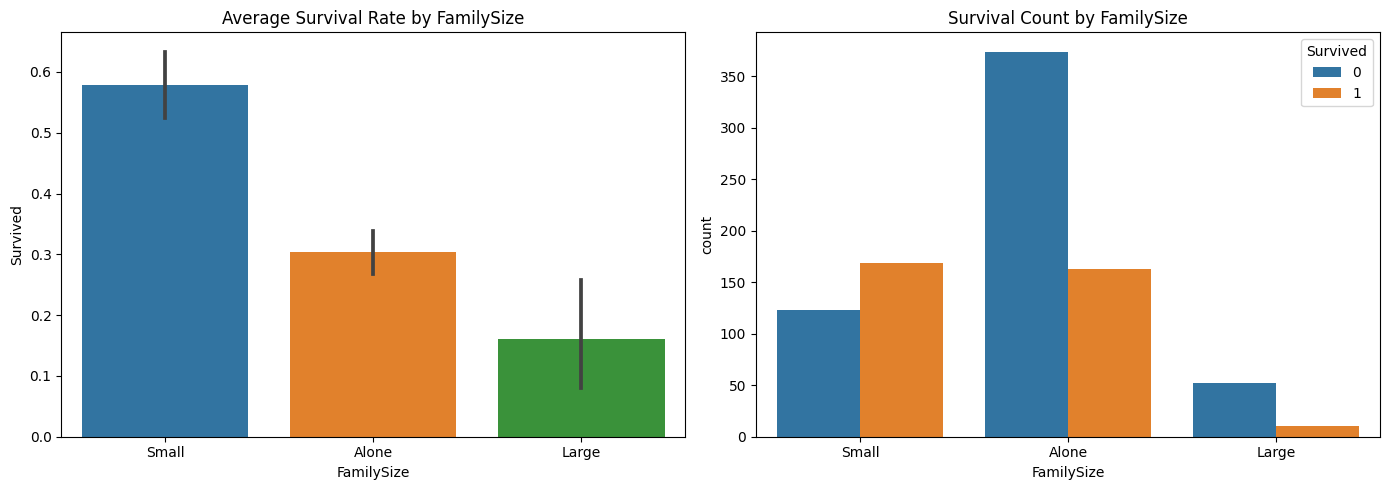

In [259]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=train_explore, x='FamilySize', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by FamilySize')

sns.countplot(data=train_explore, x='FamilySize', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by FamilySize')

plt.tight_layout();

In [260]:
# Separate data by each category
group1 = train_explore[train_explore['FamilySize'] == "Alone"]['Survived']
group2 = train_explore[train_explore['FamilySize'] == "Small"]['Survived']
group3 = train_explore[train_explore['FamilySize'] == "Large"]['Survived']

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group1, group2, group3)

print(f"F-statistic: {f_stat}, p-value: {p_value.round(3)}")

F-statistic: 40.53404584376999, p-value: 0.0


I also wonder if the proportion of ``Parch`` relative to family size affects the survival rate. My assumption is that parents and theire children were probably prioritized over those travelling alone or with siblings/spouses.

#### Create a New Feature "ParchRatio"

In [261]:
train_explore["ParchRatio"] = np.where(train_explore["SibSp"] + train_explore["Parch"] == 0,
                                      0,
                                      train_explore["Parch"] / (train_explore["SibSp"] + train_explore["Parch"]))

In [262]:
train_explore.groupby("ParchRatio", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"}).sort_values("ParchRatio", ascending = False)

,ParchRatio,Survived,Count
13,1.000000,0.661972,71
12,0.857143,0.000000,1
11,0.833333,0.333333,3
10,0.800000,0.000000,3
9,0.750000,0.333333,3
8,0.666667,0.631579,19
7,0.600000,1.000000,1
6,0.500000,0.590164,61
5,0.400000,0.285714,7
4,0.333333,0.562500,16


In [263]:
train_explore["ParchRatio"] = np.where(train_explore["ParchRatio"] == 0, 
                                       "None",
                                       np.where(train_explore["ParchRatio"] < 0.5 , "Low", "High"))

In [264]:
train_explore.groupby("ParchRatio", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,ParchRatio,Survived,Count
0,High,0.604938,162
1,Low,0.215686,51
2,None,0.343658,678


Insights:
- "High" had a higher survival rate than "Low" and "None".
- The mean survival rate for each category shows a statistically significant difference.

In [265]:
# Separate data by each category
group1 = train_explore[train_explore['ParchRatio'] == "None"]['Survived']
group2 = train_explore[train_explore['ParchRatio'] == "Low"]['Survived']
group3 = train_explore[train_explore['ParchRatio'] == "High"]['Survived']

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group1, group2, group3)

print(f"F-statistic: {f_stat}, p-value: {p_value.round(3)}")

F-statistic: 23.180980358416367, p-value: 0.0


### Embarked

In [266]:
train_explore.groupby("Embarked", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,Embarked,Survived,Count
0,C,0.553571,168
1,Q,0.389610,77
2,S,0.336957,644


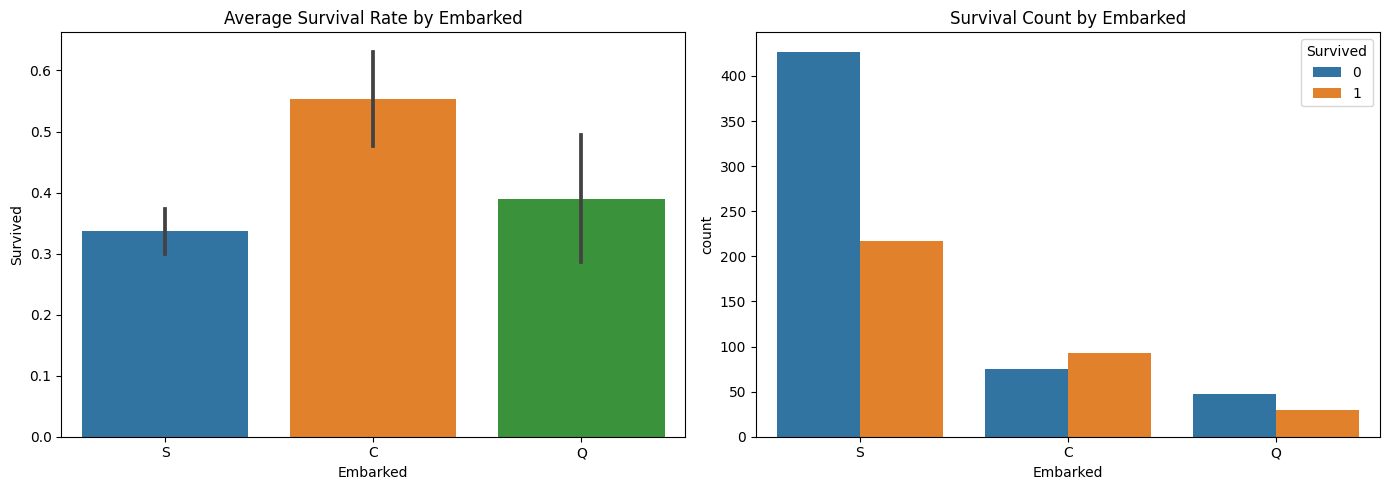

In [267]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=train_explore, x='Embarked', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by Embarked')

sns.countplot(data=train_explore, x='Embarked', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by Embarked')

plt.tight_layout();

In [268]:
# Separate data by each category
group1 = train_explore[train_explore['Embarked'] == "S"]['Survived']
group2 = train_explore[train_explore['Embarked'] == "C"]['Survived']
group3 = train_explore[train_explore['Embarked'] == "Q"]['Survived']

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group1, group2, group3)

print(f"F-statistic: {f_stat}, p-value: {p_value.round(3)}")

F-statistic: 13.605270445693582, p-value: 0.0


Insights:
- ALthough it may not be intuitive, the ANOVA test shows that there is statistical significance between the three ports of embarkation.
- Port C had the highest survival rate (55%) followed by Port Q (39%) and Port S (34%).

Let's investigate further.

#### Embarked vs. Pclass

In [269]:
pd.crosstab(index = train_explore["Embarked"], columns = train_explore["Pclass"], values = "PassengerId", aggfunc = "count")

Pclass,1,2,3
Embarked,,,
C,85,17,66
Q,2,3,72
S,127,164,353


Insights:
- About 51% of passengers who boarded at Port C were in 1st class while the rest were in 2nd/3rd class. As noted earlier, 1st class passengers had the highest survival rate over 2nd and 3rd class passengers. A significantly larger proportion of 2nd/3rd class passengers boarded at Port Q (97%) and Port S (80%).
- Therefore, it is possible that ``Embarked`` is merely reflecting the predictive power of ``Pclass``. 

Let's investigate if there is an association between the two features.

#### Perform Chi-Square Test and Calculate Cramer's V

In [270]:
contingency_table = pd.crosstab(train_explore['Embarked'], train_explore['Pclass'])

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Calculate Cramér's V, a measure of association between two categorical variables, based on the chi-square statistic.
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.2638214337231521


Insights:
- This indicates a moderate association between ``Embarked`` and ``Pclass``.
- It means that while there is some relationship between where a passenger embarked and their class, it is not an overwhelmingly strong relationship.
- This suggests that ``Embarked`` might capture some information about ``Pclass``, but it is not completely redundant.

What if we test an association between ``Embarked`` and the combination of ``Pclass`` and ``Sex``?

In [271]:
# Create an interaction term
train_explore['Pclass_Sex'] = train_explore['Pclass'].astype(str) + '_' + train_explore['Sex'].astype(str)

contingency_table = pd.crosstab(train_explore['Embarked'], train_explore['Pclass_Sex'])

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Calculate Cramér's V
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.28973771900479534


Insights:
- We observed a slight increase in the Cramer's V association score. 
- For now, I will keep the ``Embarked`` feature. 

While I was analyzing ``Embarked``, I noticed that the combination of ``Pclass`` and ``Sex`` can be helpful when predicting survivors.

#### Create an Interaction Term "Sex_Pclass"

In [272]:
train_explore.groupby(["Sex", "Pclass"]).agg({"PassengerId": "count", "Survived": "mean"})

PassengerId  Survived
Sex    Pclass                       
female 1                94  0.968085
       2                76  0.921053
       3               144  0.500000
male   1               122  0.368852
       2               108  0.157407
       3               347  0.135447

Insights:
- When ``Sex`` was female and ``Pclass`` was either 1st-class or 2nd class, the survival rate was very high (over 95%).
- On the other hand, when ``Sex`` was male and ``Pclass`` was either 2nd class or 3rd class, the survival rate was very low (around 15%).

Let's create this interaction term.

In [273]:
train_explore["Sex_Pclass"] = train_explore["Sex_Pclass"] = train_explore['Sex'].astype(str) + '_' + train_explore['Pclass'].astype(str)

### Cabin

In [274]:
len(train_explore.loc[~train_explore["Cabin"].isna()]) / len(train_explore)

0.22895622895622897

In [275]:
train_explore[["Cabin"]].head()

,Cabin
0,NaN
1,C85
2,NaN
3,C123
4,NaN


Insights:
- This feature contains about 23% of the data, with the remaining 77% being missing values.
- It is common to drop a feature when there are this many missing values. However, I noticed that a cabin number like "A10" suggests that the letter refers to the deck. After researching the ship's layout, I found that decks are described by letters (A, B, C, etc.).

First, let's determine why the column is missing data (MAR? MCAR? or MNAR?) and assess whether having recorded cabin information has a statistically significant impact on survival rate.

The ``missingno`` library is useful for visualizing and analyzing missing data. The matrix plot ('msno.matrix') displays a data matrix where missing data is shown in a different color, helping see the pattern of missingness.

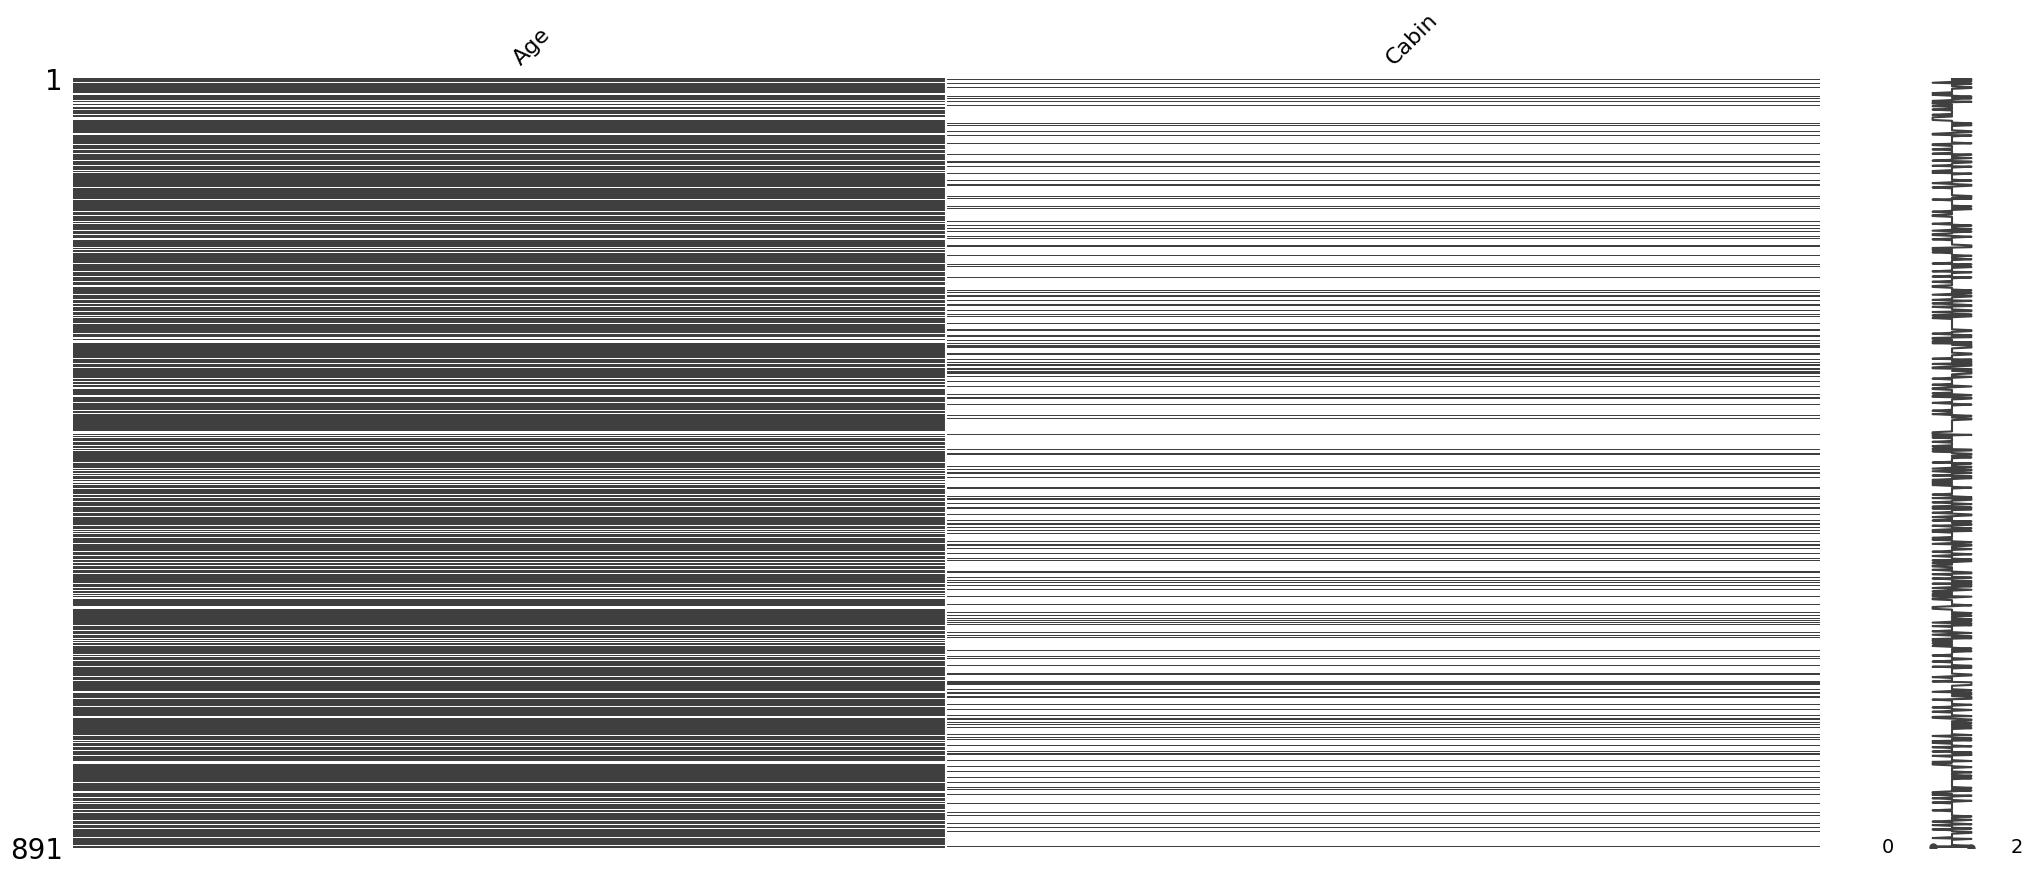

In [276]:
# Comparing with "Age" which also has a lot of missing values
msno.matrix(train_explore[["Age", "Cabin"]]);

Insights:
- Missingness of the "Cabin" feeature appears random. 

I will now create a feature that indicates whether a passenger had Cabin info or not. And then I will also create another feature that provides more detailed info about the deck (e.g., A, B, C). If using more detailed deck data proves to be more helpful more than the binary feature (Cabin Info), I will use it.

#### Create a New Feature "CabinInfo"

In [277]:
train_explore["CabinInfo"] = np.where(train_explore["Cabin"].isna(), 0, 1)

In [278]:
train_explore.groupby("CabinInfo", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,CabinInfo,Survived,Count
0,0,0.299854,687
1,1,0.666667,204


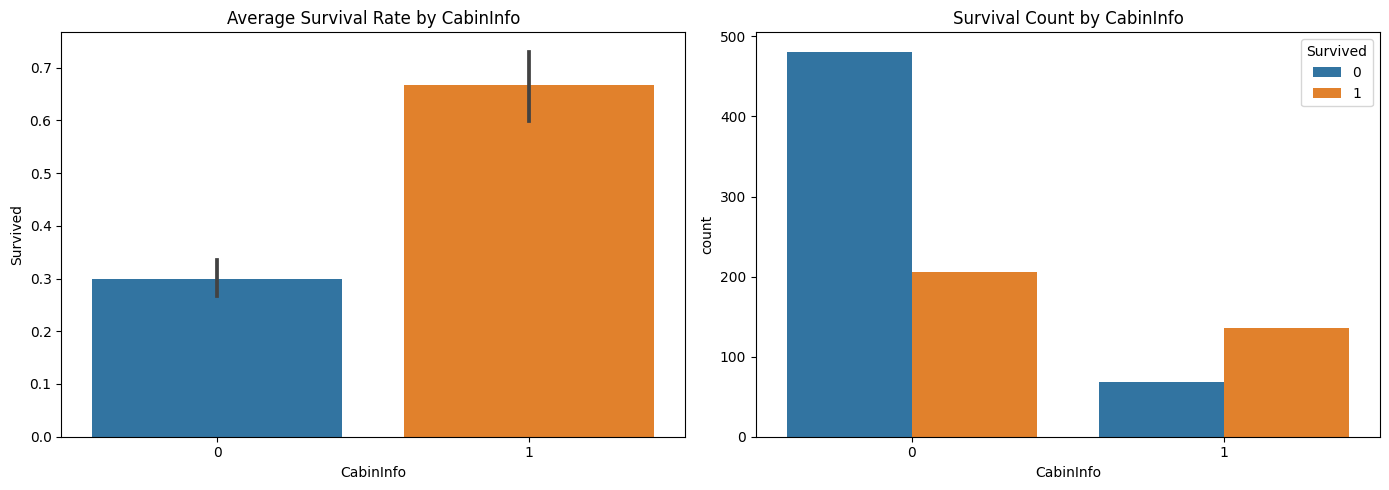

In [279]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=train_explore, x='CabinInfo', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by CabinInfo')

sns.countplot(data=train_explore, x='CabinInfo', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by CabinInfo')

plt.tight_layout();

In [280]:
# Separate data by each category
group1 = train_explore[train_explore['CabinInfo'] == 0]['Survived']
group2 = train_explore[train_explore['CabinInfo'] == 1]['Survived']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(group1, group2)

print(f"t-statistic: {t_stat}, p-value: {p_value.round(3)}")

t-statistic: -9.962587130990059, p-value: 0.0


- The mean survival rate for each category shows a statistically significant difference.

#### Create a New Feature "Deck"

In [281]:
train_explore["Cabin"] = train_explore['Cabin'].fillna("U0")
train_explore["Deck"] = train_explore['Cabin'].str.extract(r'([A-Za-z]+)', expand=False)

In [282]:
train_explore.groupby("Deck", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,Deck,Survived,Count
0,A,0.466667,15
1,B,0.744681,47
2,C,0.593220,59
3,D,0.757576,33
4,E,0.750000,32
5,F,0.615385,13
6,G,0.500000,4
7,T,0.000000,1
8,U,0.299854,687


I will further group them into "Upper" (A, B, C), "Middle" (D, E), "Lower" (F, G, T), and "Unknown" (U).

In [283]:
train_explore["Deck"] =  np.where(train_explore["Deck"].isin(["A", "B", "C"]),
                                  "Upper",
                                  np.where(train_explore["Deck"].isin(["D", "E"]), 
                                           "Middle",
                                           np.where(train_explore["Deck"] == "U", 
                                                    "Unknown",
                                                    "Lower")))

In [284]:
train_explore.groupby("Deck", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

,Deck,Survived,Count
0,Lower,0.555556,18
1,Middle,0.753846,65
2,Unknown,0.299854,687
3,Upper,0.636364,121


Insights:
- "Lower," "Middle," and "Upper" all had high survival rates. This indicates that passengers with cabin info had a better chance of surviving, regardless of which deck they were on. 
- Based on this result, I believe it is not worth complicating the feature further, so I will use the binary feature (CabinInfo).

#### Create an Interaction Term "Group?_CabinInfo"

In [285]:
pd.crosstab(index = train_explore["Group?"], columns = train_explore["CabinInfo"], values = train_explore["Survived"], aggfunc = "mean")

CabinInfo,0,1
Group?,,
0,0.248908,0.550562
1,0.401747,0.756522


In [286]:
train_explore["Group?_CabinInfo"] = train_explore["Group?"] + train_explore["CabinInfo"]

## Continuous Features

In [287]:
print(f"discrete features:    {train_explore.select_dtypes('float64').columns.values}") # float features

discrete features:    ['Age' 'Fare']


### Age

In [288]:
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na option is deprecated.*")
warnings.filterwarnings("ignore", message="When grouping with a length-1 list-like")

In [289]:
age_df = train_explore[train_explore["Age"].notna()]
age_na_df = train_explore[train_explore["Age"].isna()]

In [290]:
print(f'Size of age_df:    {len(age_df)}')
print(f'Size of age_na_df: {len(age_na_df)}')

Size of age_df:    714
Size of age_na_df: 177


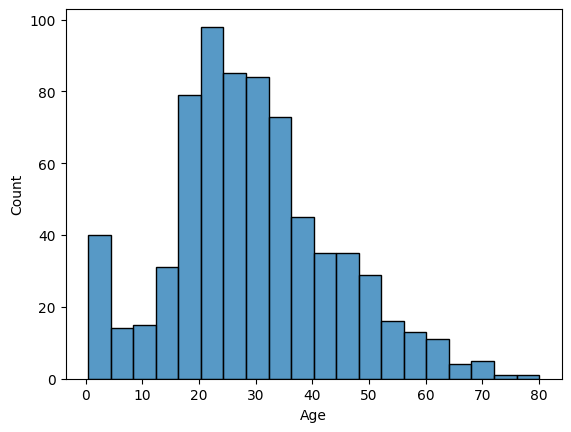

In [291]:
sns.histplot(data = age_df, x = "Age");

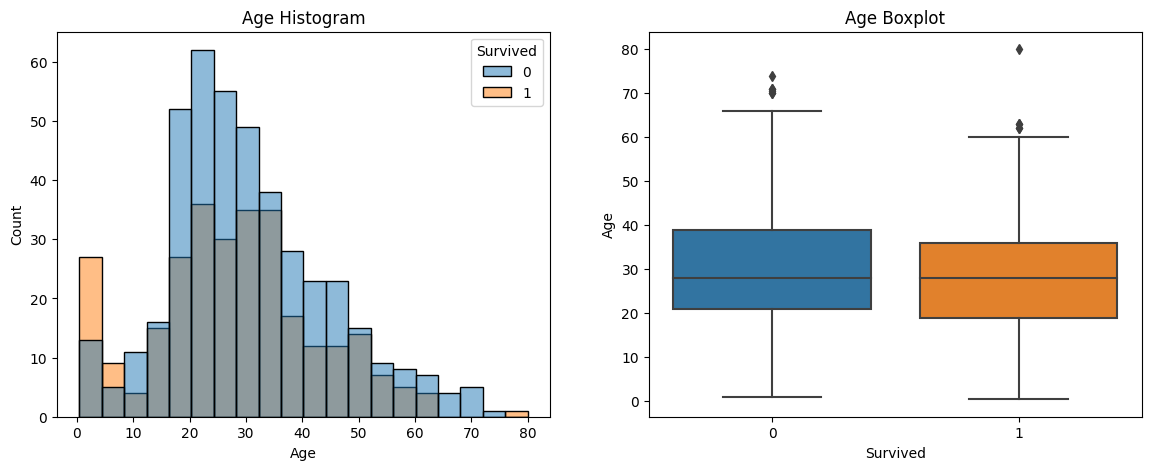

In [292]:
fig, axes = plt.subplots(1, 2, figsize = (14,5))

sns.histplot(data = age_df, x = "Age", hue = "Survived", ax = axes[0])
axes[0].set_title('Age Histogram')

sns.boxplot(data = age_df, x = "Survived", y = "Age", ax = axes[1])
axes[1].set_title("Age Boxplot");

Insights:
- Passengers aged 0-8 (or 9) years old had more survivors than victims.
- Passengers aged 16-32 years old had significantly more victims than survivors.

Remember, there are 177 missing values in ``Age`` and we need to decide how to handle them. We want to know features that do not resemle a similar distribution when plotting ``Age`` aginst them. For example, if we plot ``Age`` against ``Title``, the distribution for "Master" should be clustered in the range of 0-8. This is very different from the overall ``Age`` distribution, where a significant proportion of passengers are clustered in the range of 18-36. Therefore, using ``Title`` when imputing missing values in ``Age`` should help us estimate ages for those with the title "Master."

#### Age vs. Pclass

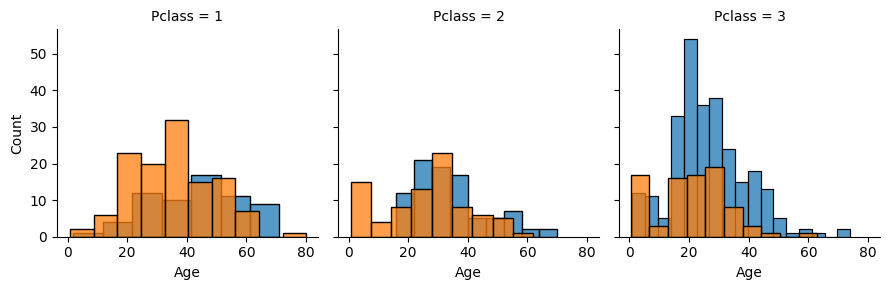

In [293]:
g = sns.FacetGrid(age_df, col="Pclass", hue = "Survived", height=3, aspect=1)

g.map(sns.histplot, "Age");

#### Age vs. Embarked

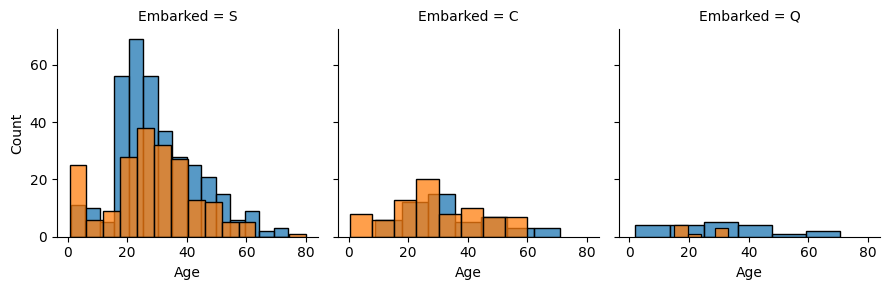

In [294]:
g = sns.FacetGrid(age_df, col="Embarked", hue = "Survived", height=3, aspect=1)

g.map(sns.histplot, "Age");

#### Age vs. Sex

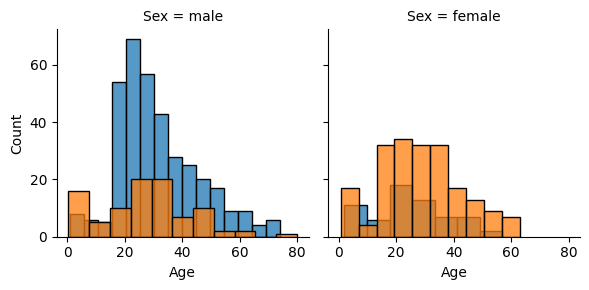

In [295]:
g = sns.FacetGrid(age_df, col="Sex", hue = "Survived", height=3, aspect=1)

g.map(sns.histplot, "Age");

#### Age vs. FamilySize

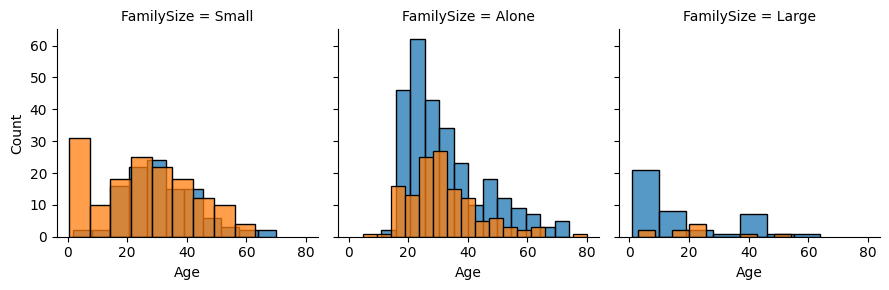

In [296]:
g = sns.FacetGrid(age_df, col="FamilySize", hue = "Survived", height=3, aspect=1)

g.map(sns.histplot, "Age");

#### Age vs. GroupSize

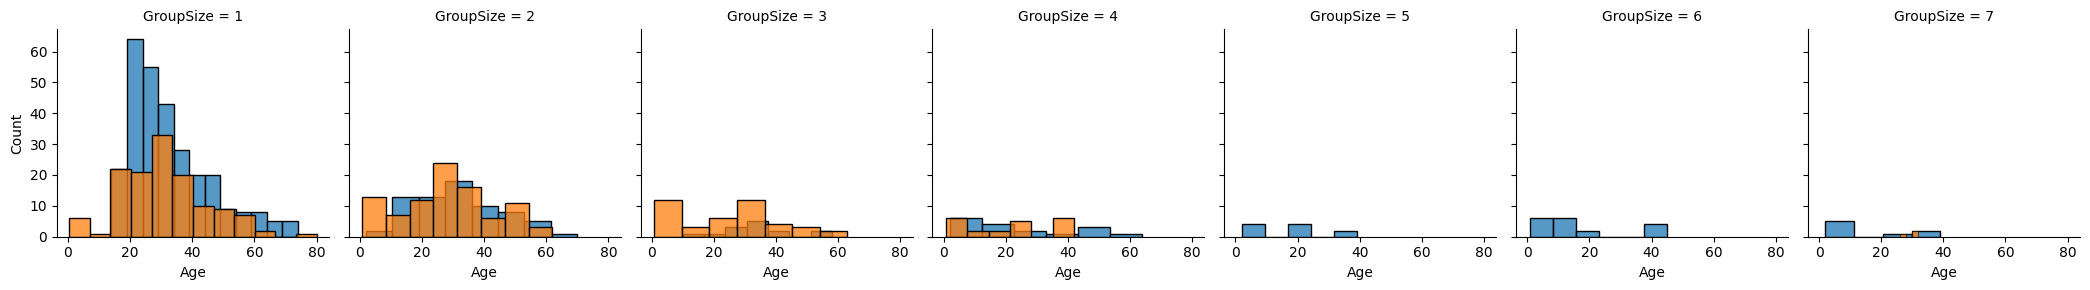

In [297]:
g = sns.FacetGrid(age_df, col="GroupSize", hue = "Survived", height=3, aspect=1)

g.map(sns.histplot, "Age");

#### Age vs. Title

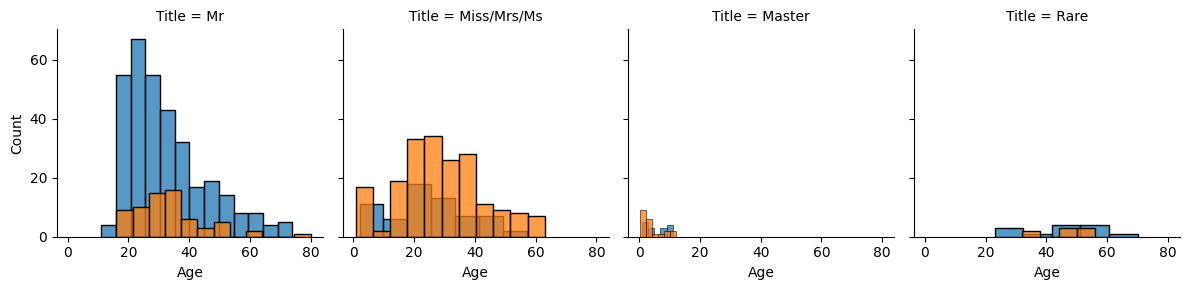

In [298]:
g = sns.FacetGrid(age_df, col="Title", hue = "Survived", height=3, aspect=1)

g.map(sns.histplot, "Age");

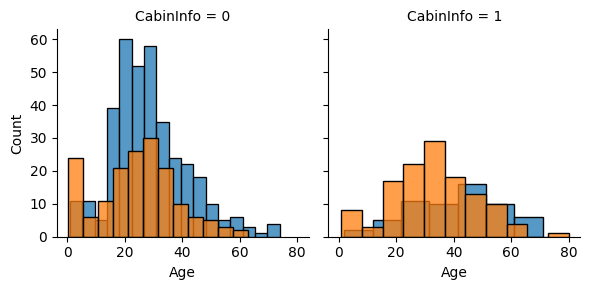

In [299]:
g = sns.FacetGrid(age_df, col="CabinInfo", hue = "Survived", height=3, aspect=1)

g.map(sns.histplot, "Age");

Insights:
- Unfortunately, most features resemble similar distributions and there do not appear to be any promissing features to estimate age...

Therefore, I will use machine learning to impute missing values with the ``IterativeImputer()``. The primary purpose of ``IterativeImputer()`` is to impute missing values in a dataset by modeling each feature with missing values as a function of other features in a round-robin fashion. It iterates through this process until convergence, filling in missing values with predicted values from the iterative model. At each iteration, a regression model (by default, Bayesian Ridge regression) is used to predict the missing values of the target feature based on the observed values of other features. 

Since it requires numeric data to impute missing values, I will apply this after converting all categorical features into numerical data.

#### Create a New Feature "AgeGroup" by Binning

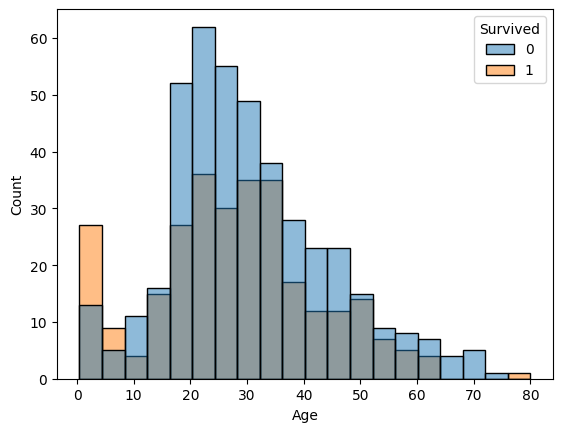

In [300]:
sns.histplot(data = age_df, x = "Age", hue = "Survived");

Automatically calculated bin width: 4.376900000000001


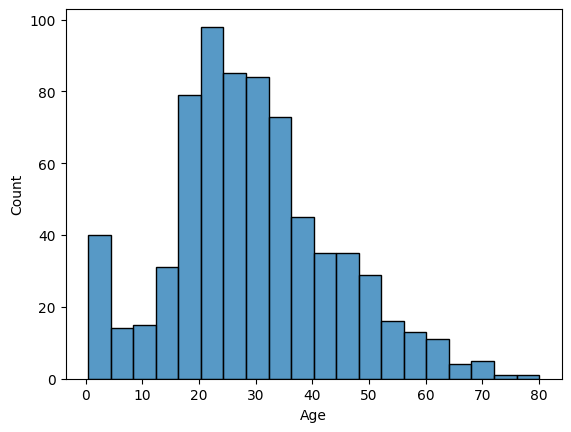

In [301]:
ax = sns.histplot(data = age_df, x = "Age")
# Get the current x-axis limits
x_min, x_max = ax.get_xlim()

# Calculate the bin width
bin_width = (x_max - x_min) / len(ax.patches)

print("Automatically calculated bin width:", bin_width)

In [302]:
# Get the bins and counts from the histogram
bins = [patch.get_x() for patch in ax.patches] + [ax.patches[-1].get_x() + ax.patches[-1].get_width()]
counts = [patch.get_height() for patch in ax.patches]

# Print the range of each bin
print("Bin Ranges:")
for i in range(len(bins) - 1):
    bin_range = (bins[i], bins[i + 1])
    bin_count = counts[i]
    print(f"Bin {i + 1}: {bin_range}, Count: {bin_count}")

Bin Ranges:
Bin 1: (0.41999999999999993, 4.399000000000001), Count: 40
Bin 2: (4.399000000000001, 8.378), Count: 14
Bin 3: (8.378, 12.357000000000003), Count: 15
Bin 4: (12.357000000000003, 16.336000000000002), Count: 31
Bin 5: (16.336000000000002, 20.315000000000005), Count: 79
Bin 6: (20.315000000000005, 24.294000000000004), Count: 98
Bin 7: (24.294000000000004, 28.273000000000003), Count: 85
Bin 8: (28.273000000000003, 32.252), Count: 84
Bin 9: (32.252, 36.231), Count: 73
Bin 10: (36.231, 40.21), Count: 45
Bin 11: (40.21, 44.18899999999999), Count: 35
Bin 12: (44.18899999999999, 48.168000000000006), Count: 35
Bin 13: (48.168000000000006, 52.147000000000006), Count: 29
Bin 14: (52.147000000000006, 56.126000000000005), Count: 16
Bin 15: (56.126000000000005, 60.105000000000004), Count: 13
Bin 16: (60.105000000000004, 64.084), Count: 11
Bin 17: (64.084, 68.06300000000002), Count: 4
Bin 18: (68.06300000000002, 72.042), Count: 5
Bin 19: (72.042, 76.02100000000002), Count: 1
Bin 20: (76.02

In [303]:
age_bins = [-np.inf, 8.4, 12.4, 16.4, 28.3, 32.3, 36.3, 48.2, 52.2, 64.1, np.inf]
age_label = ["BabyToYoungChildren", "Children", "EarlyTeens", "YoungAdultsToLate20s", "Late20sToEarly30s", "Early30sToMid30s", "Mid30sToLate40s", "Late40sToEarly50s", "Early50sToMid60s", "Mid60sToOlder"]

age_df["AgeGroup"] = pd.cut(age_df["Age"], age_bins, labels = age_label)

/tmp/ipykernel_33/3015515533.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_df["AgeGroup"] = pd.cut(age_df["Age"], age_bins, labels = age_label)


In [304]:
age_df.groupby("AgeGroup", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

/tmp/ipykernel_33/2055206599.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_df.groupby("AgeGroup", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})


,AgeGroup,Survived,Count
0,BabyToYoungChildren,0.666667,54
1,Children,0.266667,15
2,EarlyTeens,0.483871,31
3,YoungAdultsToLate20s,0.354962,262
4,Late20sToEarly30s,0.416667,84
5,Early30sToMid30s,0.479452,73
6,Mid30sToLate40s,0.356522,115
7,Late40sToEarly50s,0.482759,29
8,Early50sToMid60s,0.400000,40
9,Mid60sToOlder,0.090909,11


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


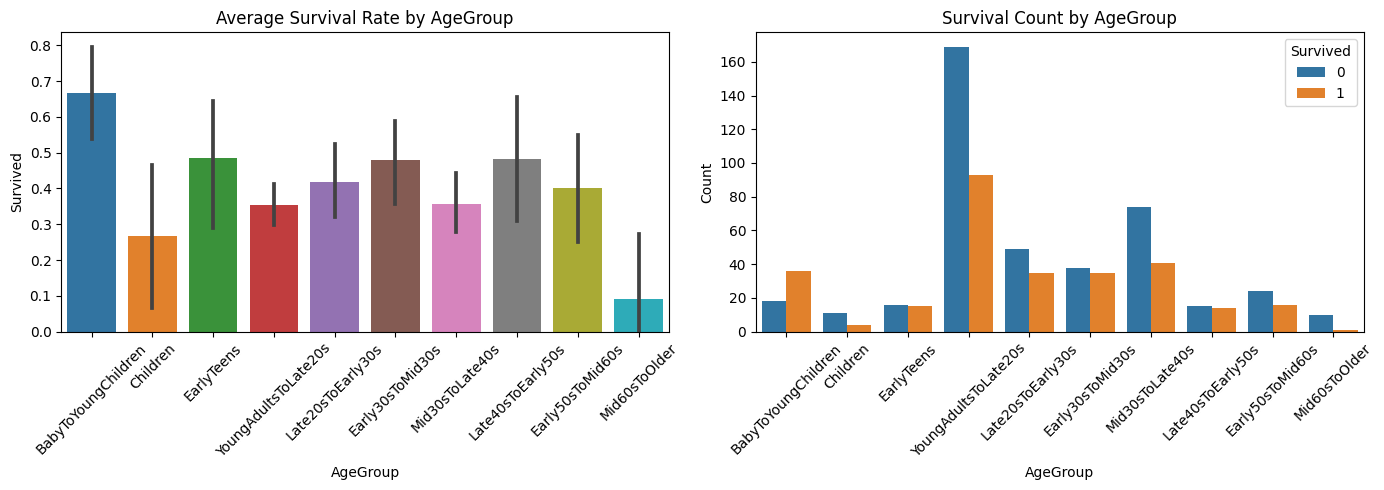

In [305]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=age_df, x='AgeGroup', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by AgeGroup')
axes[0].set_xlabel('AgeGroup')
axes[0].set_ylabel('Survived')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=age_df, x='AgeGroup', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by AgeGroup')
axes[1].set_xlabel('AgeGroup')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout();

In [306]:
# Separate data by each category
group1 = age_df[age_df['AgeGroup'] == "BabyToYoungChildren"]['Survived']
group2 = age_df[age_df['AgeGroup'] == "Children"]['Survived']
group3 = age_df[age_df['AgeGroup'] == "EarlyTeens"]['Survived']
group4 = age_df[age_df['AgeGroup'] == "YoungAdultsToLate20s"]['Survived']
group5 = age_df[age_df['AgeGroup'] == "Late20sToEarly30s"]['Survived']
group6 = age_df[age_df['AgeGroup'] == "Early30sToMid30s"]['Survived']
group7 = age_df[age_df['AgeGroup'] == "Mid30sToLate40s"]['Survived']
group8 = age_df[age_df['AgeGroup'] == "Late40sToEarly50s"]['Survived']
group9 = age_df[age_df['AgeGroup'] == "Early50sToMid60s"]['Survived']
group10 = age_df[age_df['AgeGroup'] == "Mid60sToOlder"]['Survived']

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9)

print(f"F-statistic: {f_stat}, p-value: {p_value.round(3)}")

F-statistic: 2.989573942618284, p-value: 0.003


In [307]:
age_group_mapping = {"BabyToYoungChildren": 0,
                     "Children": 1,
                     "EarlyTeens": 2,
                     "YoungAdultsToLate20s": 3,
                     "Late20sToEarly30s": 4,
                     "Early30sToMid30s": 5,
                     "Mid30sToLate40s": 6,
                     "Late40sToEarly50s": 7,
                     "Early50sToMid60s": 8,
                     "Mid60sToOlder": 9}

age_df["AgeGroup"] = age_df["AgeGroup"].map(age_group_mapping).astype("int")

/tmp/ipykernel_33/2819442735.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_df["AgeGroup"] = age_df["AgeGroup"].map(age_group_mapping).astype("int")


### Fare

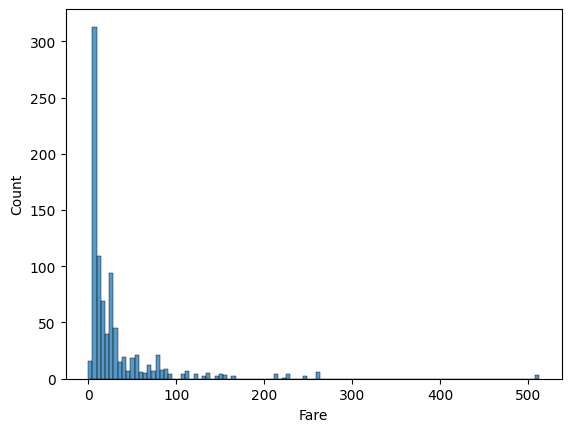

In [308]:
sns.histplot(data = train_explore, x = "Fare");

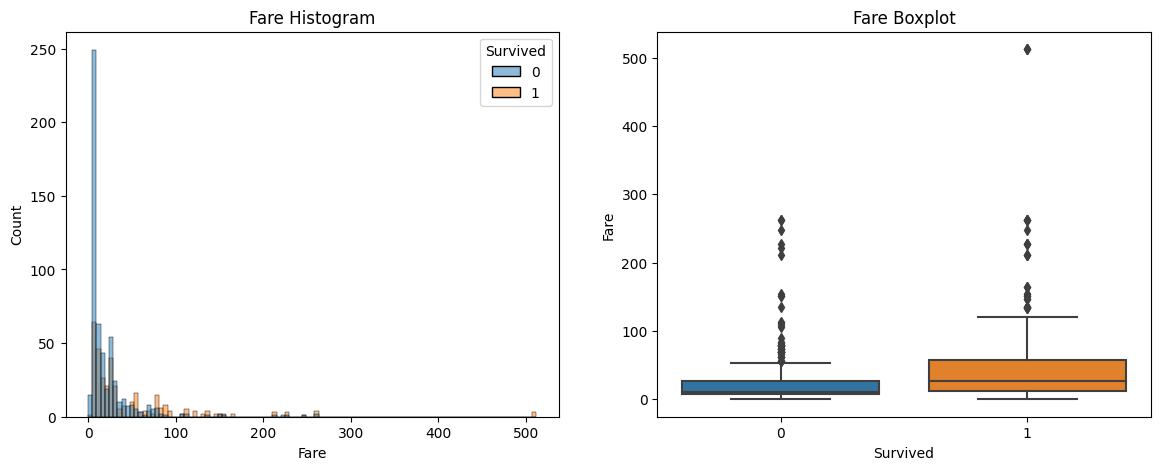

In [309]:
fig, axes = plt.subplots(1, 2, figsize = (14,5))

sns.histplot(data = train_explore, x = "Fare", hue = "Survived", ax = axes[0])
axes[0].set_title('Fare Histogram')

sns.boxplot(data = train_explore, x = "Survived", y = "Fare", ax = axes[1])
axes[1].set_title("Fare Boxplot");

Insights:
- Cheaper ``Fare`` seems to have a much lower survival rate.
- As ``Fare`` becomes more expensive, the survival rate seems to also increase.
- There is one obvious outlier where a passenger paid over 500 ``Fare``.

Let's filter out some data so that we can zoon in and take a closer look at where the most data is clustered.

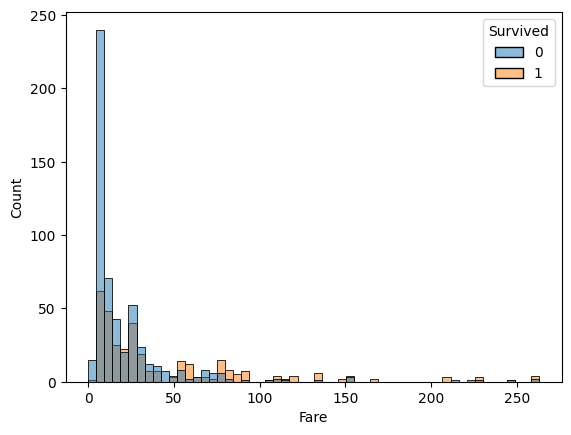

In [310]:
sns.histplot(data = train_explore.loc[train_explore["Fare"]<300], x = "Fare", hue = "Survived");

Insights:
- The majority of passengers had ``Fare`` in the range of 0-50, but the survival rate is higher when ``Fare`` is more expensive than 50.

We already know that there were 3 categories in ``Pclass``, and it is reasonable to assume that ``Fare`` varied depending on the class.

In [311]:
train_explore.groupby("Pclass")[["Fare"]].mean()

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


Insights:
- It is clear that the 1st class was the most expensive, followed by 2nd class, and then 3rd class.

It is also possible that each port of embarkation had different ``Fare``.

In [312]:
pd.crosstab(index = train_explore["Pclass"], columns = train_explore["Embarked"], values = train_explore["Fare"], aggfunc = "mean")

Embarked,C,Q,S
Pclass,,,
1,104.718529,90.000000,70.364862
2,25.358335,12.350000,20.327439
3,11.214083,11.183393,14.644083


In [313]:
pd.crosstab(index = train_explore["Pclass"], columns = train_explore["Embarked"], values = train_explore["Fare"], aggfunc = "median")

Embarked,C,Q,S
Pclass,,,
1,78.2667,90.00,52.00
2,24.0000,12.35,13.50
3,7.8958,7.75,8.05


Insights:
- The 3rd class had almost the same ``Fare`` across the three different ports, while the 1st class and the 2nd class seem to have different pricing.

Let's also examine the data along with other features.

In [314]:
train_explore.sort_values("Fare", ascending = False).head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,GroupSize,GroupSize_cat,Group?,FamilySize,ParchRatio,Pclass_Sex,Sex_Pclass,CabinInfo,Deck,Group?_CabinInfo
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,...,3,Small,1,Alone,None,1_female,female_1,0,Unknown,1
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,...,3,Small,1,Alone,None,1_male,male_1,1,Upper,2
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,...,3,Small,1,Small,High,1_male,male_1,1,Upper,2
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,...,4,Small,1,Large,Low,1_female,female_1,1,Upper,2
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,...,4,Small,1,Large,Low,1_male,male_1,1,Upper,2
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,...,4,Small,1,Large,Low,1_female,female_1,1,Upper,2
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,...,4,Small,1,Large,High,1_male,male_1,1,Upper,2
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,...,2,Small,1,Large,High,1_female,female_1,1,Upper,2
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,...,2,Small,1,Large,High,1_female,female_1,1,Upper,2
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,...,2,Small,1,Small,High,1_male,male_1,1,Upper,2


Insights:
- It appears that passengers with expensive ``Fare`` were all 1st class and group customers. We can see from the table above that there were many duplicates in the ``Ticket`` column.
- Looking at the first 3 lines, a passenger named "Cardeza, Mr. Thomas Drake Martinez" had one parent (or child) on the ship but his/her data is not shown here. This means that the data on his parent (or child) is in the test set. When performing feature engineering, we should probablly combine the training and the test set so that we can create a more accurate ``GroupSize`` data.  
 - It is reasonable to combine the training and test sets for EDA and feature engineering since the Titanic dataset is a well-known, historical dataset where the outcomes are already known, and the primary goal is to learn from this dataset for educational and exploratory purposes rather than for deploying a model in production.


Let's divide ``Fare`` by ``GroupSize`` to get ``Fare`` per person. 

#### Create a New Feature "FarePerPerson"

In [315]:
train_explore["FarePerPerson"] = train_explore["Fare"] / train_explore["GroupSize"]

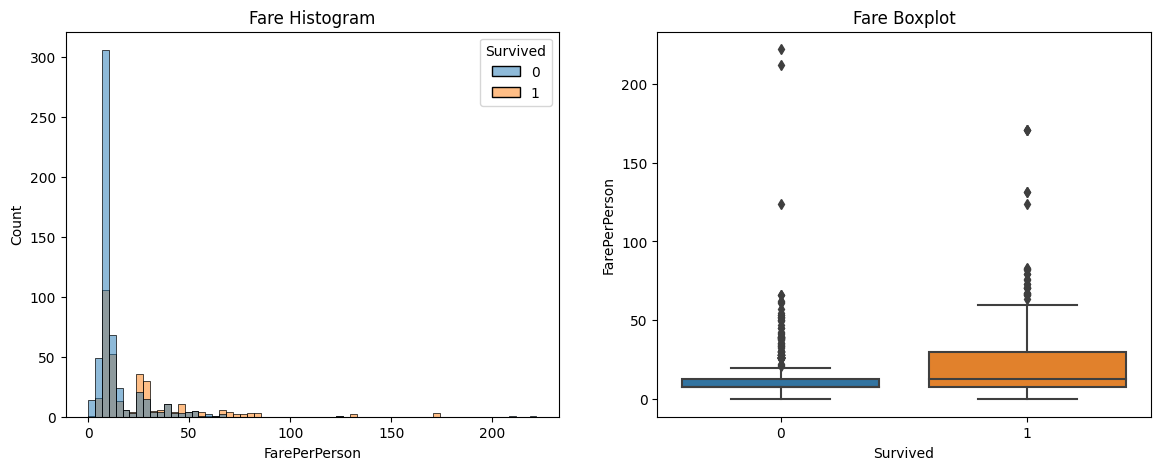

In [316]:
fig, axes = plt.subplots(1, 2, figsize = (14,5))

sns.histplot(data = train_explore, x = "FarePerPerson", hue = "Survived", ax = axes[0])
axes[0].set_title('Fare Histogram')

sns.boxplot(data = train_explore, x = "Survived", y = "FarePerPerson", ax = axes[1])
axes[1].set_title("Fare Boxplot");

In [317]:
train_explore[["Fare", "FarePerPerson", "Survived"]].corr()

,Fare,FarePerPerson,Survived
Fare,1.000000,0.839037,0.257307
FarePerPerson,0.839037,1.000000,0.254824
Survived,0.257307,0.254824,1.000000


Insights:
- ``FarePerPerson`` does not show any improvement on correlation with the target variable. 
- Therefore, I will continue to use ``Fare``, not ``FarePerPerson``.

From the oerview of both the training and test sets, we know that ``Fare`` has one missing value in the test set. Let's decide how to handle it.

#### Fare vs. Pclass vs. Embarked

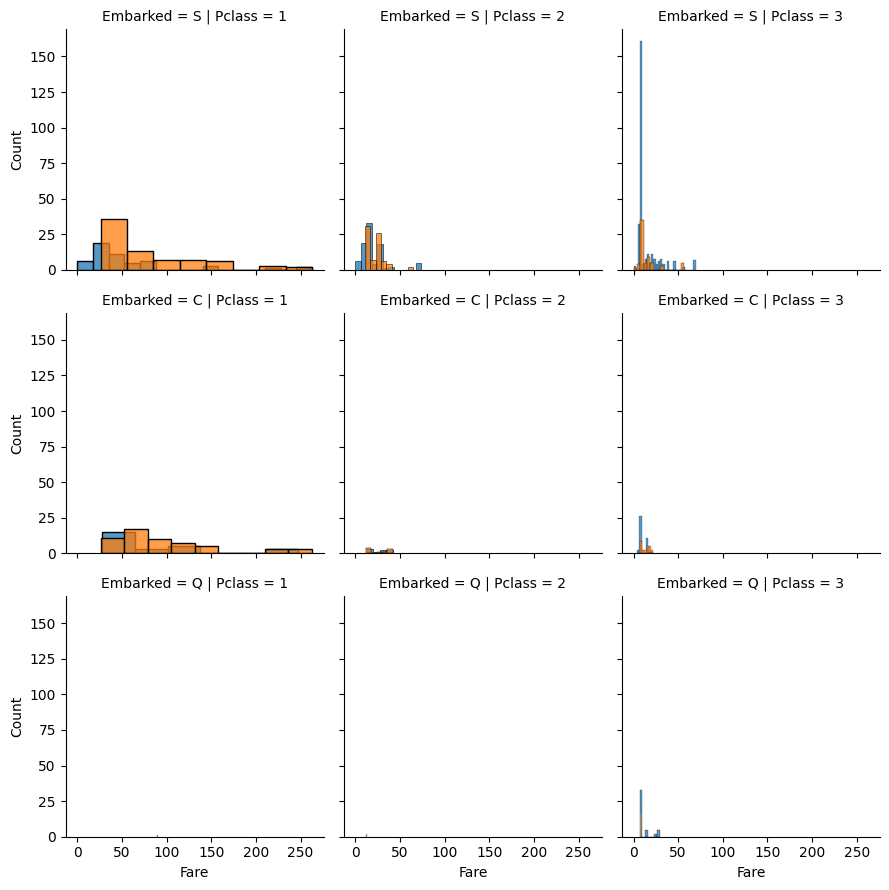

In [318]:
g = sns.FacetGrid(train_explore.loc[train_explore["Fare"]<300], col="Pclass", row = "Embarked", hue = "Survived", height=3, aspect=1)

g.map(sns.histplot, "Fare");

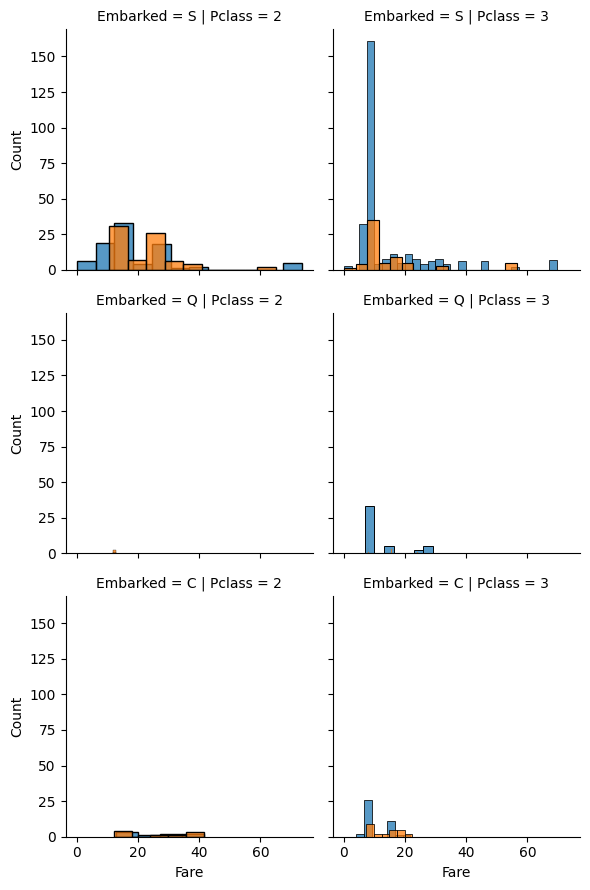

In [319]:
# to take a closer look at distribution of 2nd and 3rd class
mask = (train_explore["Fare"]<300) & (train_explore["Pclass"] != 1)

g = sns.FacetGrid(train_explore.loc[mask], col="Pclass", row = "Embarked", hue = "Survived", height=3, aspect=1)

g.map(sns.histplot, "Fare");

Insights:
- From the first chart, we can see that the class had a different distribution compared to 2nd class and 3rd class.
- From the second chart, we can observe that the 2nd class had a higher proportion of passengers who paid 15 or more ``Fare`` while the majority of 3rd class passengers paid between 14-15.

Given that there is only one missing value, it should be good enough to estimate ``Fare`` based on ``Pclass`` and ``Embarked``.

In [320]:
train_explore["MedianFare"] = train_explore.groupby(["Pclass", "Embarked"])["Fare"].transform("median")

train_explore["Fare"] = train_explore["Fare"].fillna(train_explore['MedianFare'])

train_explore = train_explore.drop("MedianFare", axis = 1)

In [321]:
train_explore.groupby(["Pclass", "Embarked"])["Fare"].median()

Pclass  Embarked
1       C           78.2667
        Q           90.0000
        S           52.0000
2       C           24.0000
        Q           12.3500
        S           13.5000
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [322]:
test[test["Fare"].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


#### Create a New Feature "FareGroup" by Binning

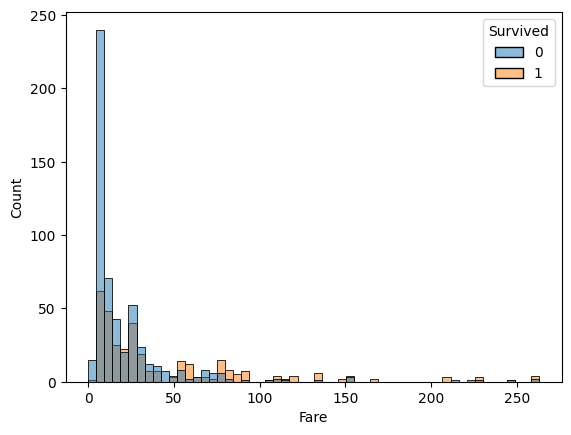

In [323]:
sns.histplot(data = train_explore.loc[train_explore["Fare"]<300], x = "Fare", hue = "Survived");

Automatically calculated bin width: 5.166071428571427


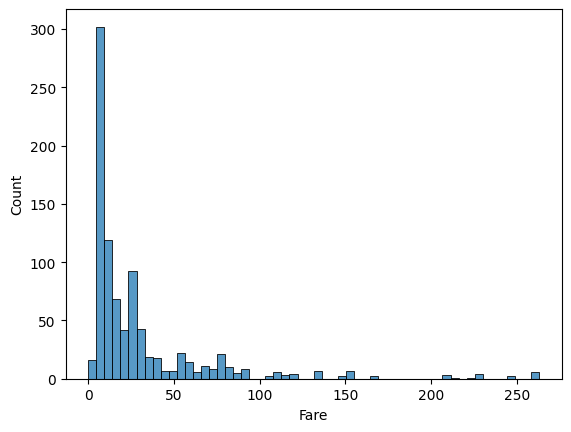

In [324]:
ax = sns.histplot(data = train_explore.loc[train_explore["Fare"]<300], x = "Fare")
# Get the current x-axis limits
x_min, x_max = ax.get_xlim()

# Calculate the bin width
bin_width = (x_max - x_min) / len(ax.patches)

print("Automatically calculated bin width:", bin_width)

In [325]:
# Get the bins and counts from the histogram
bins = [patch.get_x() for patch in ax.patches] + [ax.patches[-1].get_x() + ax.patches[-1].get_width()]
counts = [patch.get_height() for patch in ax.patches]

# Print the range of each bin
print("Bin Ranges:")
for i in range(len(bins) - 1):
    bin_range = (bins[i], bins[i + 1])
    bin_count = counts[i]
    print(f"Bin {i + 1}: {bin_range}, Count: {bin_count}")

Bin Ranges:
Bin 1: (0.0, 4.696428571428571), Count: 16
Bin 2: (4.696428571428571, 9.392857142857142), Count: 302
Bin 3: (9.392857142857142, 14.089285714285715), Count: 119
Bin 4: (14.089285714285715, 18.785714285714285), Count: 68
Bin 5: (18.785714285714285, 23.482142857142854), Count: 42
Bin 6: (23.482142857142854, 28.17857142857143), Count: 92
Bin 7: (28.17857142857143, 32.875), Count: 43
Bin 8: (32.875, 37.57142857142857), Count: 19
Bin 9: (37.57142857142857, 42.26785714285714), Count: 18
Bin 10: (42.26785714285714, 46.96428571428571), Count: 7
Bin 11: (46.96428571428571, 51.660714285714285), Count: 7
Bin 12: (51.660714285714285, 56.357142857142854), Count: 22
Bin 13: (56.357142857142854, 61.053571428571416), Count: 14
Bin 14: (61.053571428571416, 65.75), Count: 6
Bin 15: (65.75, 70.44642857142858), Count: 11
Bin 16: (70.44642857142858, 75.14285714285714), Count: 8
Bin 17: (75.14285714285714, 79.83928571428572), Count: 21
Bin 18: (79.83928571428572, 84.53571428571428), Count: 10
Bin

In [326]:
fare_bins = [-np.inf, 9.4, 28.2, 51.7, 103.4, np.inf]
fare_label = ["Group1", "Group2", "Group3", "Group4", "Group5"]

train_explore["FareGroup"] = pd.cut(train_explore["Fare"], fare_bins, labels = fare_label)

In [327]:
train_explore.groupby("FareGroup", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})

/tmp/ipykernel_33/905060345.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_explore.groupby("FareGroup", as_index = False).agg({"Survived": "mean", "PassengerId": "count"}).rename(columns = {"PassengerId": "Count"})


,FareGroup,Survived,Count
0,Group1,0.198113,318
1,Group2,0.420561,321
2,Group3,0.382979,94
3,Group4,0.657143,105
4,Group5,0.735849,53


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


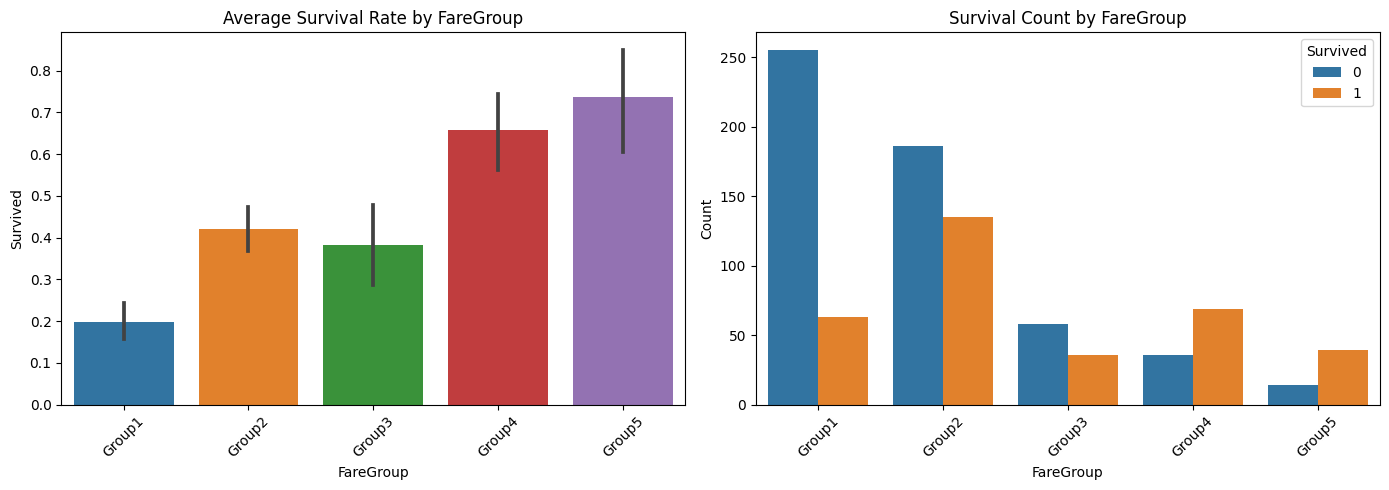

In [328]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=train_explore, x='FareGroup', y='Survived', ax=axes[0])
axes[0].set_title('Average Survival Rate by FareGroup')
axes[0].set_xlabel('FareGroup')
axes[0].set_ylabel('Survived')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=train_explore, x='FareGroup', hue='Survived', ax=axes[1])
axes[1].set_title('Survival Count by FareGroup')
axes[1].set_xlabel('FareGroup')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout();

In [329]:
# Separate data by each category
group1 = train_explore[train_explore['FareGroup'] == "Group1"]['Survived']
group2 = train_explore[train_explore['FareGroup'] == "Group2"]['Survived']
group3 = train_explore[train_explore['FareGroup'] == "Group3"]['Survived']
group4 = train_explore[train_explore['FareGroup'] == "Group4"]['Survived']
group5 = train_explore[train_explore['FareGroup'] == "Group5"]['Survived']

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group1, group2, group3, group4, group5)

print(f"F-statistic: {f_stat}, p-value: {p_value.round(3)}")

F-statistic: 30.91922153599888, p-value: 0.0


In [330]:
fare_group_mapping = {"Group1": 0,
                      "Group2": 1,
                      "Group3": 2,
                      "Group4": 3,
                      "Group5": 4}

train_explore["FareGroup"] = train_explore["FareGroup"].map(fare_group_mapping).astype("int")

Now that we have explored many features and gained a much deeper understanding of the titanic data, it's time to apply this knowledge to create a final version of the dataset. MWe will perform many of the same feature engineering steps as in the EDA phase. In this section, however, we will only add new features that have been proven useful (based on our statistical tests). We will also use ``OneHotEncoder()`` and ``IterativeImputer()`` to impute missing values in ``Age`` and create a new feature by binning ``Age``.

# Feature Engineering

- Extract ``Title`` from ``Name`` and map them 
- Create ``GroupSize`` from ``Ticket`` and map them
- Convert ``Pclass`` into object
- Create ``FamilySize`` from ``SibSp`` and ``Parch`` and map them
- Calculate ``ParchRatio`` using ``FamilySize`` and ``Parch``
- Create ``CabinInfo`` from ``Cabin``
- Impute missing values in ``Embarked``
- Create an interaction term ``Pclass_Sex_Embarked``
- Impute a missing value in ``Fare``
- Create ``FareGroup`` by Binning
- Drop unnecessary features
- Split the dataframe back into the training and test sets
- OneHotEncoding
- Impute missing values in ``Age`` by using ``IterativeImputer()`` 
- Create ``AgeGroup`` from ``Age``

In [331]:
train_df = train.copy()
test_df = test.copy()

all_df = pd.concat([train_df, test_df]).reset_index(drop = True)

train_end_idx = 891

In [332]:
# all_df.iloc[:train_end_idx]
# all_df.loc[:train_end_idx - 1]

In [333]:
# Etract ``Title`` from ``Name`` and map them 
all_df['Title'] = all_df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)

# mapping dict based on the training set
title_mapping = {"Mr": "Mr",
                 "Miss": "Miss/Mrs/Ms",
                 "Mrs": "Miss/Mrs/Ms",
                 "Master": "Master",
                 "Dr": "Rare",
                 "Rev": "Rare", # Typically refers to someone who holds a clerical or ministerial position within a religious organization
                 "Major": "Rare", # Typically refers to someone who holds a senior position below that of a Lieutenant Colonel and above that of a Captain
                 "Col": "Rare", # Typically refers to someone who holds the military rank of Colonel
                 "Mlle": "Miss/Mrs/Ms", # "Mademoiselle" in French, equivalent to "Miss"
                 "Mme": "Miss/Mrs/Ms", # "Madame" in French, equivalent to "Mrs"
                 "Ms": "Miss/Mrs/Ms", # Neutral alternative to "Miss" or "Mrs"
                 "Capt": "Rare", # Typically refers to someone who holds the rank of Captain in the military or other organizations
                 "Lady": "Rare", # Women of high social rank or noble birth
                 "Jonkheer": "Rare", # Young nobleman
                 "Don": "Rare", # Man of high rank or nobility
                 "Countess": "Rare", # Wife or widow of a count in European countries with a nobiliary system
                 "Sir": "Rare" # Men of knighthood or baronetcy in English-speaking countries
                }

# fill with "Rare" if there is any title that did not appear in the training set
all_df["Title"] = all_df["Title"].map(title_mapping).fillna("Rare")

# Create ``GroupSize`` from ``Ticket`` and map them
groupsize_mapping = all_df[:train_end_idx].groupby("Ticket")["PassengerId"].count().to_dict()
all_df["Group?"] = all_df["Ticket"].map(groupsize_mapping)
all_df["Group?"] = all_df["Group?"].fillna(-1) # unique in the test set
all_df.loc[:train_end_idx - 1, "Group?"] = np.where(all_df.loc[:train_end_idx - 1, "Group?"] > 1,
                                                 1,
                                                 0)
all_df.loc[train_end_idx:, "Group?"] = np.where(all_df.loc[train_end_idx:, "Group?"] > 0, # in case that ticket no. appeard only once in the training set but appeared again in the test set
                                                 1,  
                                                 all_df.loc[train_end_idx:, "Group?"]) # -1

# all_df["GroupSize_cat"] = np.where(all_df["GroupSize"] == 0,
#                                    "N/A",
#                                    np.where(all_df["GroupSize"] == 1, 
#                                            "Alone",
#                                            np.where(all_df["GroupSize"].isin([2,3,4]), 
#                                                     "Small",
#                                                     "Large"))

# Convert ``Pclass`` into object
all_df["Pclass"] = all_df["Pclass"].astype("object")

# Create ``FamilySize`` from ``SibSp`` and ``Parch`` and map them
all_df["FamilySize"] = all_df["SibSp"] + all_df["Parch"] + 1

all_df["FamilySize"] = np.where(all_df["FamilySize"] == 1, 
                                "Alone",
                                np.where(all_df["FamilySize"].isin([2,3,4]), 
                                         "Small",
                                         "Large"))

# Calculate ``ParchRatio`` using ``FamilySize`` and ``Parch``
all_df["ParchRatio"] = np.where(all_df["SibSp"] + all_df["Parch"] == 0,
                                0,
                                all_df["Parch"] / (all_df["SibSp"] + all_df["Parch"]))

all_df["ParchRatio"] = np.where(all_df["ParchRatio"] == 0, 
                                "None",
                                np.where(all_df["ParchRatio"] < 0.5 , 
                                         "Low", 
                                         "High"))

# Create ``CabinInfo`` from ``Cabin``
all_df["CabinInfo"] = np.where(all_df["Cabin"].isna(), 0, 1)

# Impute missing values in ``Embarked``
most_freq = all_df.iloc[:train_end_idx-1]["Embarked"].mode()[0]

all_df["Embarked"] = all_df["Embarked"].fillna(most_freq)

# Create an interaction term ``Pclass_Sex_Embarked``
# all_df["Pclass_Sex_Embarked"] = all_df["Pclass"].astype(str) + '_' + all_df["Sex"].astype(str) + '_' + all_df["Embarked"].astype(str)
all_df["Pclass_Sex"] = all_df["Pclass"].astype(str) + '_' + all_df["Sex"].astype(str)
# all_df["Pclass_Title"] = all_df["Pclass"].astype(str) + '_' + all_df["Title"].astype(str)

# Create an interaction term "Group?_CabinInfo"
all_df["Group?_CabinInfo"] = all_df["Group?"] + all_df["CabinInfo"]

# Impute a missing value in ``Fare``
Pclass_3_Embarked_S = 8.05

all_df["Fare"] = all_df["Fare"].fillna(Pclass_3_Embarked_S)

# Create ``FareGroup`` by Binning
fare_bins = [-np.inf, 9.4, 28.2, 51.7, 103.4, np.inf]
fare_label = [0, 1, 2, 3, 4]

all_df["FareGroup"] = pd.cut(all_df["Fare"], fare_bins, labels = fare_label).astype("int")

# Drop unnecessary features
drop_cols = ["PassengerId", "Name", "Ticket", "SibSp", "Parch","Cabin", "Fare"]

all_df = all_df.drop(drop_cols, axis = 1)

# Split the dataframe back into the training and test set
train_df = all_df.iloc[:train_end_idx]
test_df = all_df.iloc[train_end_idx:].reset_index(drop = True)

X_train = train_df.drop("Survived", axis = 1)
y_train = train_df["Survived"]
X_test = test_df.drop("Survived", axis = 1)

# OneHotEncoding
cat_cols = ["Pclass", "Sex", "Title", "FamilySize", "Embarked", "ParchRatio", "Pclass_Sex"]
# "GroupSize_cat", "ParchRatio", "Embarked", "Pclass_Sex_Embarked",  "Pclass_Title"

enc = OneHotEncoder(handle_unknown = "ignore", drop = 'if_binary')

train_enc_data = enc.fit_transform(X_train[cat_cols])
train_enc_df = pd.DataFrame(train_enc_data.toarray(), columns = enc.get_feature_names_out(cat_cols))
X_train_enc = pd.concat([X_train, train_enc_df], axis=1).drop(cat_cols, axis = 1)

test_enc_data = enc.transform(X_test[cat_cols])
test_enc_df = pd.DataFrame(test_enc_data.toarray(), columns = enc.get_feature_names_out(cat_cols))
X_test_enc = pd.concat([X_test, test_enc_df], axis=1).drop(cat_cols, axis = 1)

# Impute missing values in ``Age`` by using ``IterativeImputer()`` 
imputer = IterativeImputer(max_iter = 10, random_state = 42)

X_train_r = imputer.fit_transform(X_train_enc)
X_train_r = pd.DataFrame(X_train_r, columns=X_train_enc.columns)

X_test_r = imputer.transform(X_test_enc)
X_test_r = pd.DataFrame(X_test_r, columns=X_test_enc.columns)

# Create ``AgeGroup`` from ``Age``
age_bins = [-np.inf, 8.4, 12.4, 16.4, 28.3, 32.3, 36.3, 48.2, 52.2, 64.1, np.inf]
age_label = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

combined = [X_train_r, X_test_r]

for df in combined:
    df["AgeGroup"] = pd.cut(df["Age"], age_bins, labels = age_label).astype("int")
    df.drop("Age", axis = 1, inplace = True)

Now that our data is ready, it's finally time to feed it to machine learning algorithms. I have already done hyperparameter tuniong for each model, so let's examine which model performs well.

# Modeling

## Logistic Regression

In [334]:
lr_best_params = {'C': 0.3, 'penalty': 'l2'}

In [335]:
lr = LogisticRegression(**lr_best_params, max_iter = 5000, random_state = 42)

score_train_lr = cross_val_score(lr, X_train_r, y_train, cv=5, n_jobs = -1, scoring = "accuracy").round(3)
score_train_mean_lr = score_train_lr.mean().round(3)
y_pred = cross_val_predict(lr, X_train_r, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_lr}')
print(f'Mean Train Accuracy: {score_train_mean_lr}')

Train Score: [0.832 0.82  0.837 0.815 0.871]
Mean Train Accuracy: 0.835


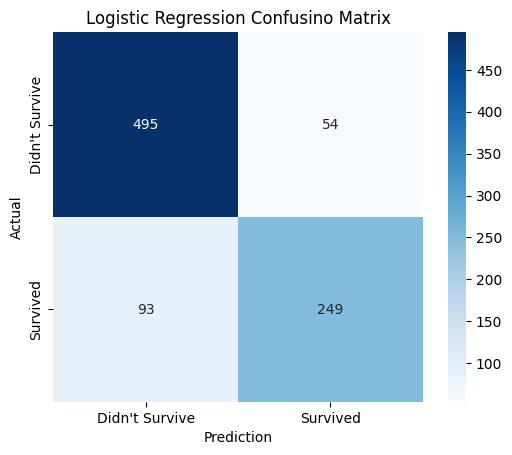

In [336]:
lr_confusion_matrix = confusion_matrix(y_train, y_pred)

beautified_confusion_matrix(lr_confusion_matrix, 'Logistic Regression')

## SVC

In [337]:
svc_best_params = {'C': 0.4, 'gamma': 0.03, 'kernel': 'rbf'}

In [338]:
svc = SVC(**svc_best_params, random_state = 42)

score_train_svc = cross_val_score(svc, X_train_r, y_train, cv=5, n_jobs = -1, scoring = "accuracy").round(3)
score_train_mean_svc = score_train_svc.mean().round(3)
y_pred = cross_val_predict(svc, X_train_r, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_svc}')
print(f'Mean Train Accuracy: {score_train_mean_svc}')

Train Score: [0.844 0.826 0.826 0.781 0.854]
Mean Train Accuracy: 0.826


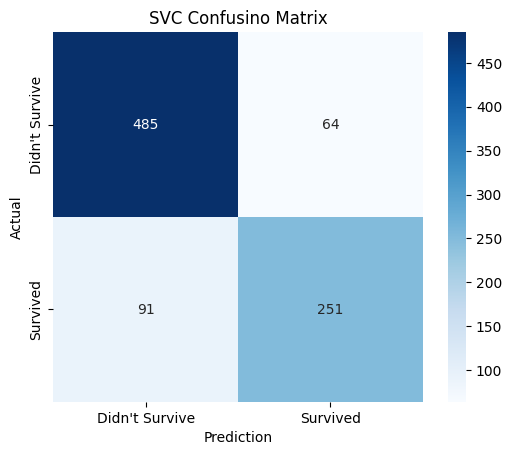

In [339]:
svc_confusion_matrix = confusion_matrix(y_train, y_pred)

beautified_confusion_matrix(svc_confusion_matrix, 'SVC')

## KNN

In [340]:
knn_best_params = {'algorithm': 'kd_tree', 'n_neighbors': 24, 'weights': 'uniform'}

In [341]:
knn = KNeighborsClassifier(**knn_best_params) 

score_train_knn = cross_val_score(knn, X_train_r, y_train, cv=5, n_jobs = -1, scoring = "accuracy").round(3)
score_train_mean_knn = score_train_knn.mean().round(3)
y_pred = cross_val_predict(knn, X_train_r, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_knn}')
print(f'Mean Train Accuracy: {score_train_mean_knn}')

Train Score: [0.816 0.775 0.831 0.787 0.865]
Mean Train Accuracy: 0.815


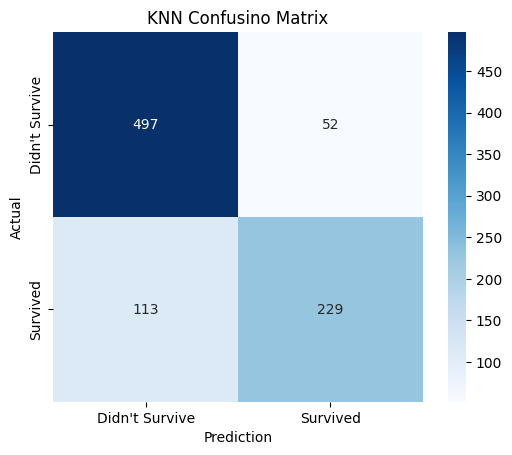

In [342]:
knn_confusion_matrix = confusion_matrix(y_train, y_pred)

beautified_confusion_matrix(knn_confusion_matrix, 'KNN')

##  GaussianNB

In [343]:
gnb_best_params = {'var_smoothing': 0.001873817422860383}

In [344]:
gnb = GaussianNB(**gnb_best_params)

score_train_gnb = cross_val_score(gnb, X_train_r, y_train, cv=5, n_jobs = -1, scoring = "accuracy").round(3)
score_train_mean_gnb = score_train_gnb.mean().round(3)
y_pred = cross_val_predict(gnb, X_train_r, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_gnb}')
print(f'Mean Train Accuracy: {score_train_mean_gnb}')

Train Score: [0.743 0.803 0.831 0.798 0.865]
Mean Train Accuracy: 0.808


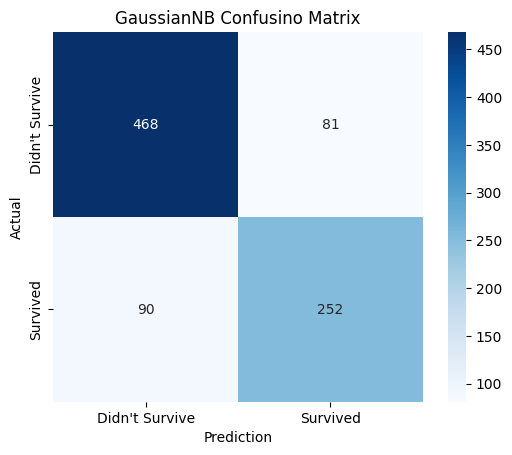

In [345]:
gnb_confusion_matrix = confusion_matrix(y_train, y_pred)

beautified_confusion_matrix(gnb_confusion_matrix, 'GaussianNB')

## Random Forest

In [346]:
rf_best_params = {'max_depth': 5,
 'max_features': 'log2',
 'max_leaf_nodes': 11,
 'max_samples': 0.95,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 880}

In [347]:
rf = RandomForestClassifier(**rf_best_params, random_state = 42)

score_train_rf = cross_val_score(rf, X_train_r, y_train, cv=5, n_jobs = -1, scoring = "accuracy").round(3)
score_train_mean_rf = score_train_rf.mean().round(3)
y_pred = cross_val_predict(rf, X_train_r, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_rf}')
print(f'Mean Train Accuracy: {score_train_mean_rf}')

Train Score: [0.816 0.826 0.826 0.803 0.854]
Mean Train Accuracy: 0.825


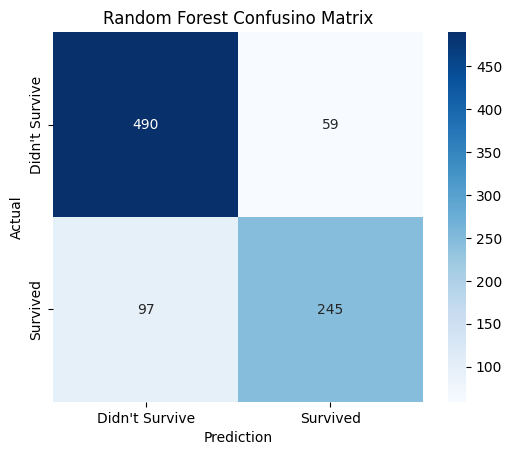

In [348]:
rf_confusion_matrix = confusion_matrix(y_train, y_pred)

beautified_confusion_matrix(rf_confusion_matrix, 'Random Forest')

### Feature Importances
For tree-based models, we can also obtain feature importances. Feature importance in tree-based models refers to techniques used to determine the contribution of each feature to the prediction accuracy of the model. It helps in understanding which features are most influential in predicting the target variable.

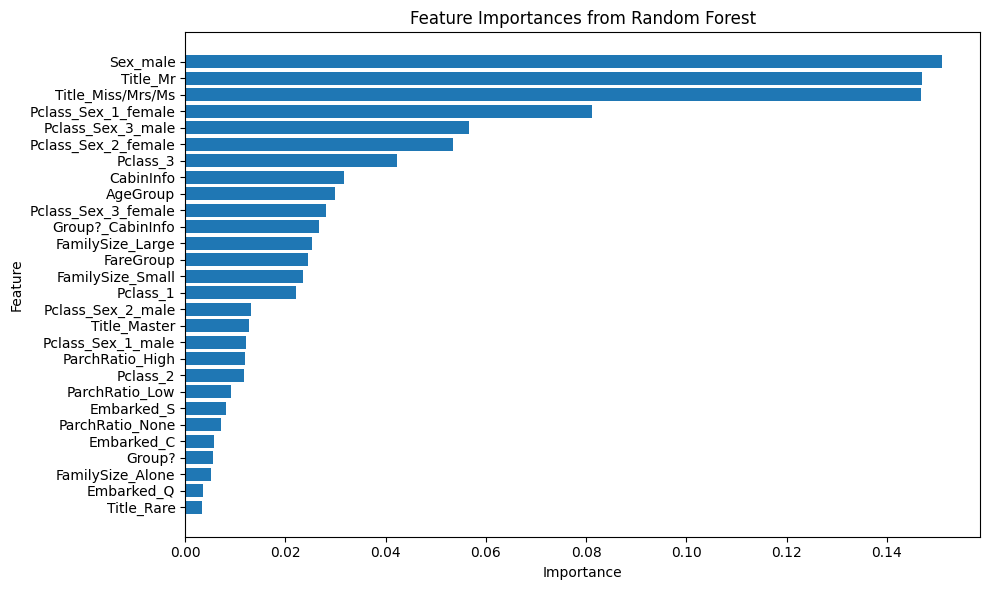

In [349]:
rf.fit(X_train_r, y_train)

importances = rf.feature_importances_
feature_names = X_train_r.columns

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Gradient Boosting

In [350]:
gb_best_params = {'learning_rate': 0.01,
 'max_depth': 4,
 'max_features': 'sqrt',
 'max_leaf_nodes': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 170,
 'subsample': 0.9}

In [351]:
gb = GradientBoostingClassifier(**gb_best_params)

score_train_gb = cross_val_score(gb, X_train_r, y_train, cv=5, n_jobs = -1, scoring = "accuracy").round(3)
score_train_mean_gb = score_train_gb.mean().round(3)
y_pred = cross_val_predict(gb, X_train_r, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_gb}')
print(f'Mean Train Accuracy: {score_train_mean_gb}')

Train Score: [0.855 0.82  0.831 0.803 0.86 ]
Mean Train Accuracy: 0.834


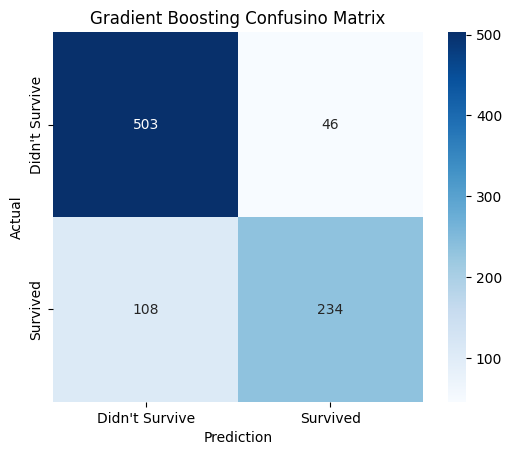

In [352]:
gb_confusion_matrix = confusion_matrix(y_train, y_pred)

beautified_confusion_matrix(gb_confusion_matrix, 'Gradient Boosting')

### Feature Importances

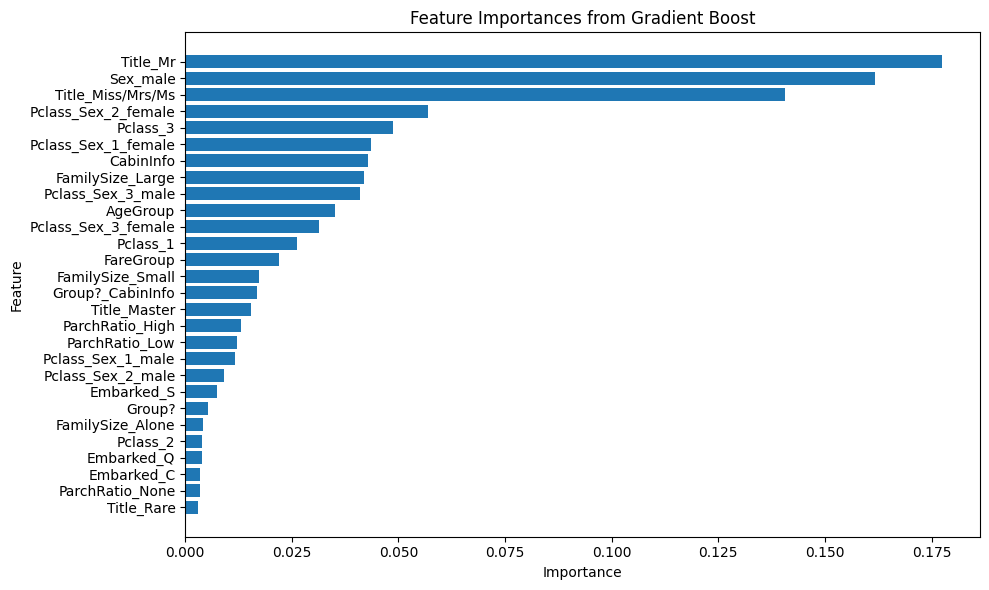

In [353]:
gb.fit(X_train_r, y_train)

importances = gb.feature_importances_
feature_names = X_train_r.columns

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## XGB

In [354]:
xgb_best_params = {'colsample_bytree': 0.95,
 'learning_rate': 0.01,
 'max_depth': 5,
 'max_leaves': 50,
 'n_estimators': 190,
 'reg_alpha': 10,
 'reg_lambda': 10,
 'subsample': 0.95}

In [355]:
xgb = XGBClassifier(**xgb_best_params, random_state = 42)

score_train_xgb = cross_val_score(xgb, X_train_r, y_train, cv=5, n_jobs = -1, scoring = "accuracy").round(3)
score_train_mean_xgb = score_train_xgb.mean().round(3)
y_pred = cross_val_predict(xgb, X_train_r, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_xgb}')
print(f'Mean Train Accuracy: {score_train_mean_xgb}')

Train Score: [0.793 0.815 0.826 0.803 0.865]
Mean Train Accuracy: 0.82


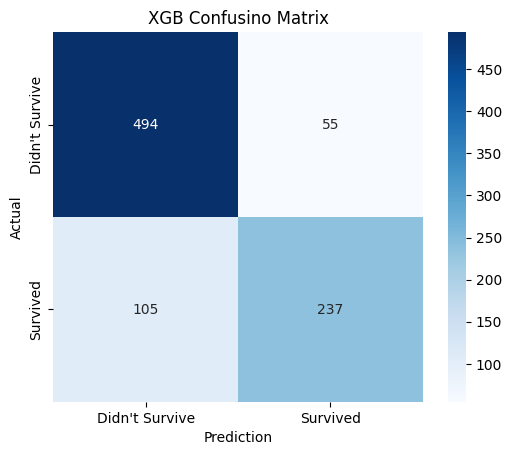

In [356]:
xgb_confusion_matrix = confusion_matrix(y_train, y_pred)

beautified_confusion_matrix(xgb_confusion_matrix, 'XGB')

### Feature Importances

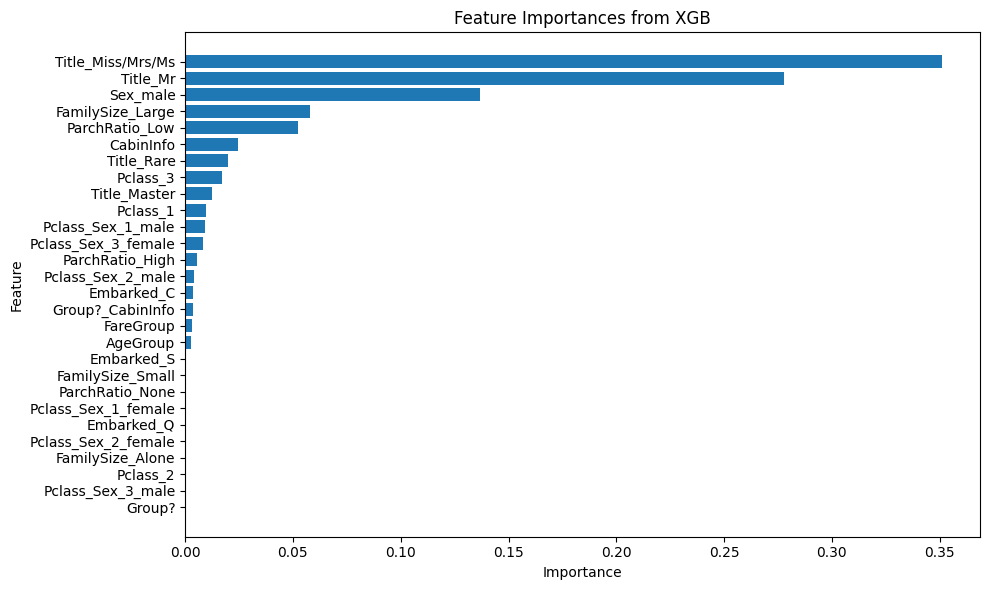

In [357]:
xgb.fit(X_train_r, y_train)

importances = xgb.feature_importances_
feature_names = X_train_r.columns

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGB')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## AdaBoost

In [358]:
ada_best_params = {'algorithm': 'SAMME', 'learning_rate': 0.2, 'n_estimators': 1000}

In [359]:
ada = AdaBoostClassifier(**ada_best_params, random_state = 42)

score_train_ada = cross_val_score(ada, X_train_r, y_train, cv=5, n_jobs = -1, scoring = "accuracy").round(3)
score_train_mean_ada = score_train_ada.mean().round(3)
y_pred = cross_val_predict(ada, X_train_r, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_ada}')
print(f'Mean Train Accuracy: {score_train_mean_ada}')

Train Score: [0.804 0.803 0.815 0.803 0.848]
Mean Train Accuracy: 0.815


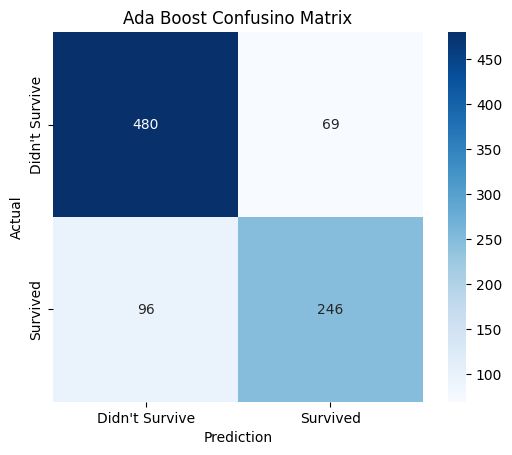

In [360]:
ada_confusion_matrix = confusion_matrix(y_train, y_pred)

beautified_confusion_matrix(ada_confusion_matrix, 'Ada Boost')

### Feature Importances

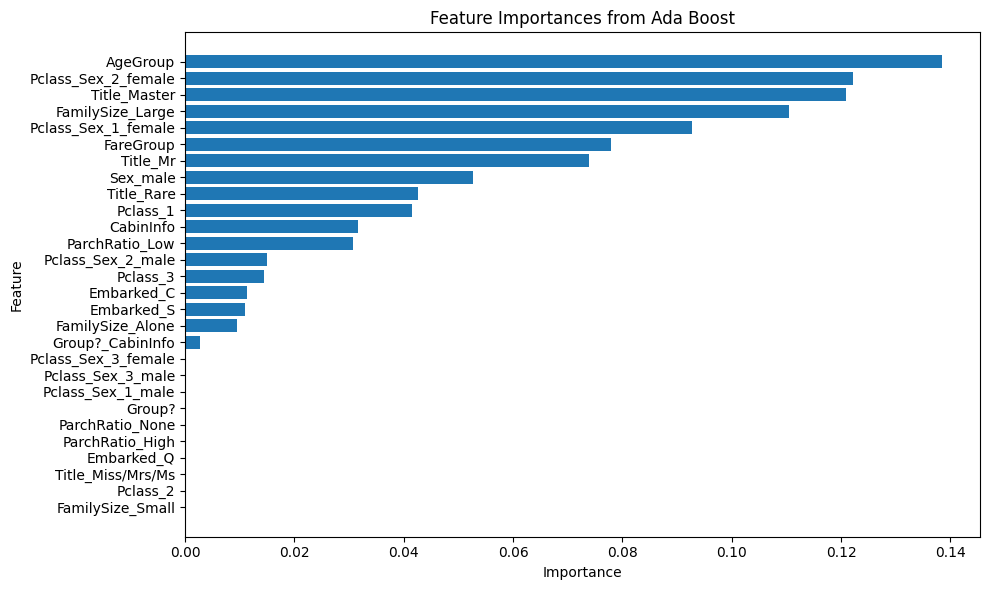

In [361]:
ada.fit(X_train_r, y_train)

importances = ada.feature_importances_
feature_names = X_train_r.columns

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Ada Boost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## CatBoost

In [362]:
cat_best_params = {'rsm': 0.9,
 'random_strength': 1,
 'learning_rate': 0.01,
 'l2_leaf_reg': 9,
 'iterations': 100,
 'depth': 14,
 'border_count': 256,
 'bagging_temperature': 1}

In [363]:
cat = CatBoostClassifier(**cat_best_params, verbose = False, random_state = 42)

score_train_cat = cross_val_score(cat, X_train_r, y_train, cv=5, n_jobs = -1, scoring = "accuracy").round(3)
score_train_mean_cat = score_train_cat.mean().round(3)
y_pred = cross_val_predict(cat, X_train_r, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_cat}')
print(f'Mean Train Accuracy: {score_train_mean_cat}')

Train Score: [0.804 0.809 0.826 0.792 0.86 ]
Mean Train Accuracy: 0.818


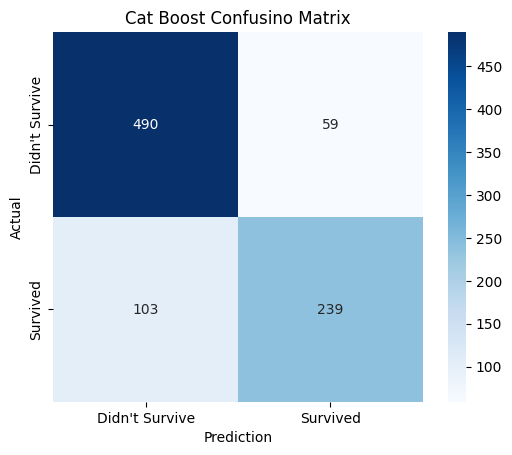

In [364]:
cat_confusion_matrix = confusion_matrix(y_train, y_pred)

beautified_confusion_matrix(cat_confusion_matrix, 'Cat Boost')

### Feature Importances

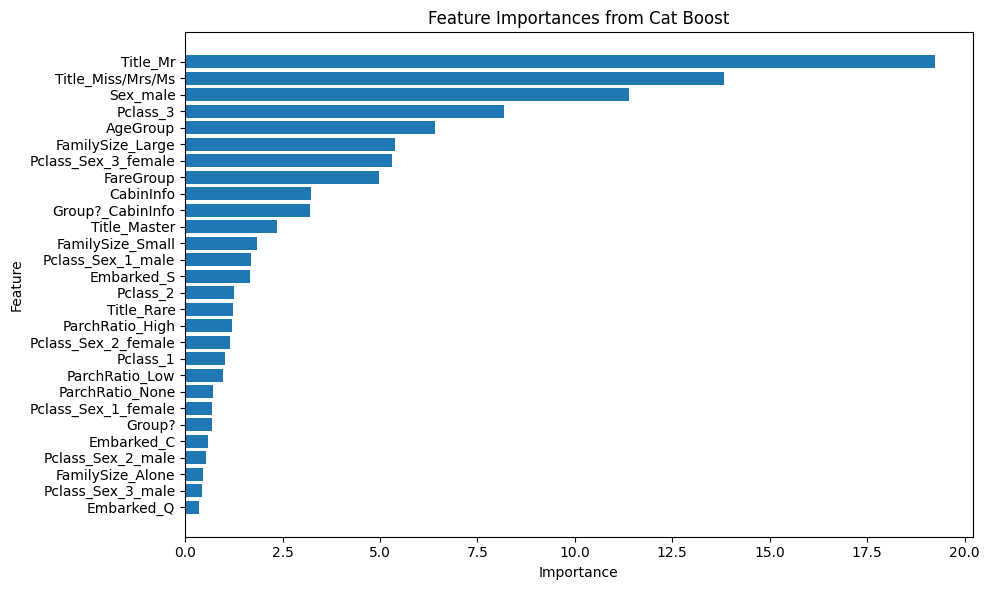

In [365]:
cat.fit(X_train_r, y_train)

importances = cat.feature_importances_
feature_names = X_train_r.columns

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Cat Boost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Voting

In [366]:
vt = VotingClassifier(
            estimators = [
                ('lr', LogisticRegression(**lr_best_params, max_iter = 5000, random_state= 42)),
#                 ('svc', SVC(**svc_best_params, probability = True)),
                ('rf', RandomForestClassifier(**rf_best_params, random_state = 42)),
#                 ('gb', GradientBoostingClassifier(**gb_best_params)),
#                 ('ada', AdaBoostClassifier()),
#                 ('xgb', XGBClassifier(**xgb_best_params)),
#                 ('cat', CatBoostClassifier(**cat_best_params, verbose = False, random_state = 42))
            ], 
            voting = 'hard')

score_train_vt = cross_val_score(vt, X_train_r, y_train, cv=5, n_jobs = -1, scoring = "accuracy").round(3)
score_train_mean_vt = score_train_vt.mean().round(3)
y_pred = cross_val_predict(vt, X_train_r, y_train, cv=5) # will use this when plotting a confusion matrix

print(f'Train Score: {score_train_vt}')
print(f'Mean Train Accuracy: {score_train_mean_vt}')

Train Score: [0.827 0.82  0.843 0.798 0.848]
Mean Train Accuracy: 0.827


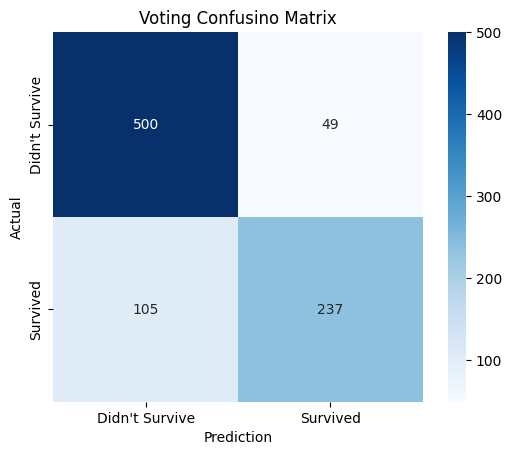

In [367]:
vt_confusion_matrix = confusion_matrix(y_train, y_pred)

beautified_confusion_matrix(vt_confusion_matrix, 'Voting')

In [368]:
# vt.fit(X_train_r, y_train)
# y_pred = lr.predict(X_test_r).astype("int")

# submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": y_pred}).reset_index(drop = True)

# submission.to_csv('V6_vt.csv', index = False)

# Evaluation

Let's create a summary table and see what model was the best performer. 

In [369]:
summary = {"Linear Regression": score_train_mean_lr,
           "SVC": score_train_mean_svc,
           "GaussianNB": score_train_mean_gnb,
           "KNN": score_train_mean_knn,
           "Radom Forest": score_train_mean_rf,
           "Gradient Boost": score_train_mean_gb,
           "XGB": score_train_mean_xgb,
           "Ada Boost": score_train_mean_ada,
           "Cat Boost": score_train_mean_cat,
           "Voting": score_train_mean_vt,}

summary_df = pd.DataFrame(list(summary.items()), columns=["Model", "Mean Accuracy"])

In [370]:
summary_df.sort_values("Mean Accuracy", ascending = False)

,Model,Mean Accuracy
0,Linear Regression,0.835
5,Gradient Boost,0.834
9,Voting,0.827
1,SVC,0.826
4,Radom Forest,0.825
6,XGB,0.820
8,Cat Boost,0.818
3,KNN,0.815
7,Ada Boost,0.815
2,GaussianNB,0.808


Our best performing model was Linear Regression with mean accuracy of 0.834!

# Conclusion

If you are a Kaggle user, you can join the ["Titanic - Machine Learnig from Disaster"](https://www.kaggle.com/competitions/titanic/overview) competion and test how well your model performs on the test set. I have also submitted my predictions multiple times with different models and the test accuracy was in the range of 0.77 - 0.80. Given that our best model had an 83.4% accuracy on the training set, this test result indicates our model is overfitting to the training data. There are multiple techniques to address overfitting. One way is to simply the model. It is also common to increase regularization. 

ML projects are usually an iterative process: manipulate data, evaluate the model with the training set (or/and cv set), go back to the previous step and create new features or drop features. You might also consider apply more advanced techniques, such as unsupervised learning like KMeans Clustering or dimensionality reduction like PCA. 

I would like to note that if you navigate to the leaderboard on the competition page, you will see hundreds of users who got the perfect score. I tried very hard to get closer to the perfect score, but after checking some discussion threads, I learned that those people just got the answer from a certain source and changed its format so that they can submit it. I don't understand why they cheat when the purpose of the project is practice, but we should not be too stressed about the result. After watching Data Science influencers' walkthrough videos and other users' notebooks, I believe the best score we can get without cheating is probably somewhere between 0.80 - 0.83. 

Also, if you review some notebooks with high scores, you will notice that many of them combined the training and test sets and perform feature engineering. While it is convenient to combine the two to handle missing values (like we did in this kernel), creating new features based on both the training and test set is called _data leakage_, and this should be avoided. Otherwise, your model will produce overly optimistic predictions. I have combined the two datasets, too, but I made sure not to use the data from the test set when creating features like "Title" and "Group?". This is a competition so I understand that we want the high score possible, but it is very important to be aware of data leakage and avoid it at all costs in real-life projects.

Thank you very much for reading this kernel!

Seiji